# **ML Project**
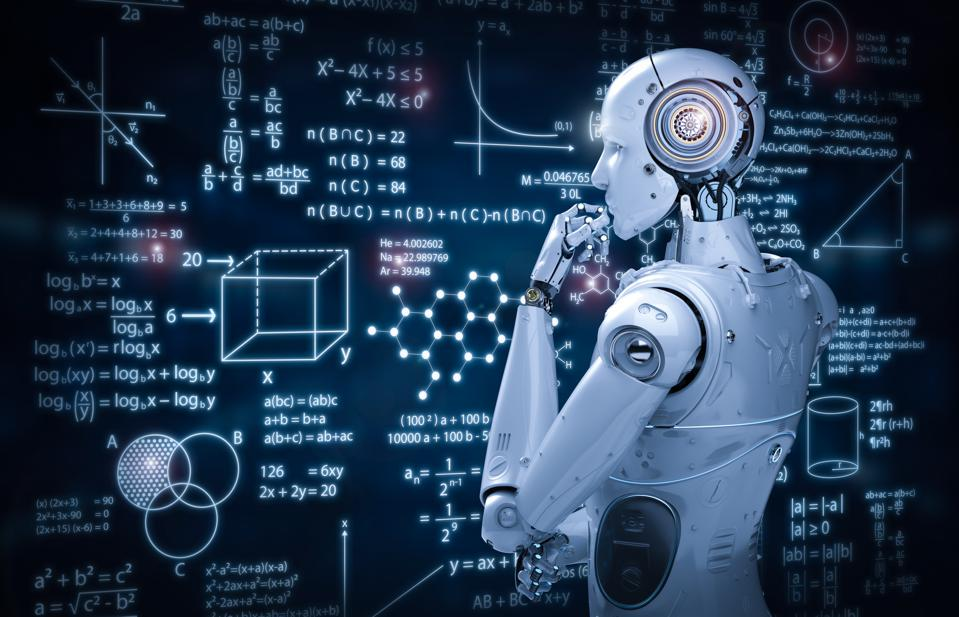
### Aharon Malkin 

In [1]:
!pip install scipy
!pip install seaborn==0.11.2


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import auc
from sklearn.decomposition import PCA
from sklearn.metrics import RocCurveDisplay, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, auc, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif
from sklearn.metrics import roc_curve
from scipy import stats
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from scipy import stats
from scipy.stats.mstats import winsorize
from numpy import interp
from sklearn import svm
from typing import Dict ,List

data = pd.read_csv("train.csv")
pd.set_option('display.max_columns', None)

# Data Exploration
On this section, we want to get familiar with our data!
Let's visualize and learn some interesting insights from it.

We have 10K entries and 23 features (which is a lot!) we believe that dimension reduction might be neccessary.

In [3]:
data.shape

(10479, 23)

Getting some statistical facts about our data is neccesary for the pre-proccesing step, and also to look for interesting details, such as this one:
There is a significant difference on the "duration" features between **mean** and **median**, it may say that there are outliers in those features.

In [4]:
data.describe()


,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,num_of_product_pages,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,device,Region,B,D,purchase
count,10479.00000,9874.000000,10066.000000,9792.000000,10076.000000,5726.000000,10457.000000,10453.000000,10452.000000,9983.000000,10156.000000,10460.000000,10456.000000,105.000000,10479.000000
mean,5239.00000,2.321957,80.462468,0.502655,31.870187,1302.457216,0.021854,0.042859,5.900387,0.061985,2.122981,3.155641,99.769628,4.060440,0.154690
std,3025.17107,3.335331,179.217548,1.265812,44.816259,2039.312905,0.048100,0.048297,18.727496,0.199429,0.906859,2.404672,10.050268,2.189818,0.361626
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,60.733919,-1.235571,0.000000
25%,2619.50000,0.000000,0.000000,0.000000,7.000000,221.000000,0.000000,0.014283,0.000000,0.000000,2.000000,1.000000,93.030568,3.141657,0.000000
50%,5239.00000,1.000000,8.000000,0.000000,18.000000,677.851191,0.002968,0.025161,0.000000,0.000000,2.000000,3.000000,99.787249,4.432221,0.000000
75%,7858.50000,4.000000,93.000000,0.000000,38.000000,1605.733333,0.016667,0.050000,0.000000,0.000000,3.000000,4.000000,106.506626,5.531061,0.000000
max,10478.00000,27.000000,3398.750000,24.000000,705.000000,47850.920680,0.200000,0.200000,361.763742,1.000000,8.000000,9.000000,141.735142,7.618254,1.000000


From what we see, there are few features that we can change, so they would be helpful:
1. String to numeric values, such as: product page duration and info page duration
2. We have few Categorial features: user type, region, C, browser, Month. We can make some of them dummies.


In [5]:
#Let's see what's the different types of our features:
feature_summary= data.info(verbose=False, memory_usage=False)
print(feature_summary)

#Which features are not numeric?
all_cols = data.columns
numeric = data.select_dtypes(include=[np.number]).columns
bool_cols = data.select_dtypes(include=['bool']).columns
cat_cols = list(set(all_cols) - set(numeric)-set(bool_cols))

# those 2 are pretending to be numberic but they aren't
cat_cols.append('Region')
cat_cols.append('device')

print('\n',"The features who have a string dtype are:", cat_cols)





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10479 entries, 0 to 10478
Columns: 23 entries, id to purchase
dtypes: float64(13), int64(2), object(8)None

 The features who have a string dtype are: ['Weekend', 'A', 'info_page_duration', 'product_page_duration', 'user_type', 'internet_browser', 'C', 'Month', 'Region', 'device']


Let's check the null values in our data. The null values are a significant element, as filling them should be done thoughtfully, with statistical & Bussines considerations!

We see that:
1.   D feature is almost empty
2.   Total duration is half empty (47%) but it's not critical, as info, product and admin duration are the sum of total duration feature, and they <500 values missing so we can complete it

    

<AxesSubplot:>

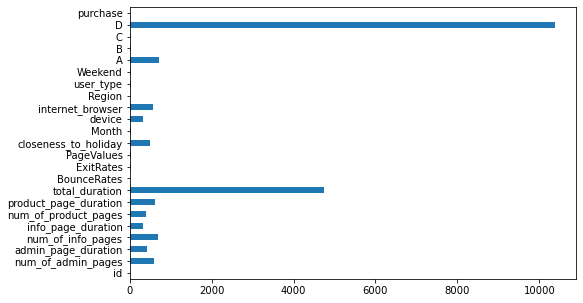

In [6]:
#How many features has null value??
plt.figure(figsize=(8,5))
data.isnull().sum().plot(kind='barh')

To observe which feature is important, we would like to explore the **correlation** between the numeric features.
Thus, we remove for this plot the categorial features and also the id feature, which isn't important

An important note is that the non numeric features are'nt included in this plot, and we would like to visulize them as well to have better understanding.

In [7]:
plt.figure(figsize=(10,5))
#removing the categorial features and the id that is part of each dataframe
corr = data.drop(['Region','device','id'],axis=1).corr()
corr_new= corr.style.background_gradient(cmap='coolwarm').set_properties(**{'font-size': '7pt'})

corr_new

,num_of_admin_pages,admin_page_duration,num_of_info_pages,num_of_product_pages,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,B,D,purchase
num_of_admin_pages,1.000000,0.591505,0.383974,0.436619,0.447180,-0.222772,-0.317713,0.102648,-0.099734,-0.016465,-0.197337,0.145048
admin_page_duration,0.591505,1.000000,0.297256,0.291797,0.445325,-0.141197,-0.202072,0.068009,-0.072091,-0.018782,-0.110871,0.097504
num_of_info_pages,0.383974,0.297256,1.000000,0.382615,0.489927,-0.116471,-0.165944,0.046150,-0.051921,-0.021416,-0.167875,0.095563
num_of_product_pages,0.436619,0.291797,0.382615,1.000000,0.877881,-0.202365,-0.292254,0.057020,-0.027799,-0.019066,-0.326672,0.157167
total_duration,0.447180,0.445325,0.489927,0.877881,1.000000,-0.192154,-0.265104,0.054231,-0.049315,-0.026004,-0.236378,0.145429
BounceRates,-0.222772,-0.141197,-0.116471,-0.202365,-0.192154,1.000000,0.911589,-0.116746,0.081161,0.008744,0.147855,-0.150683
ExitRates,-0.317713,-0.202072,-0.165944,-0.292254,-0.265104,0.911589,1.000000,-0.172314,0.111041,0.007393,0.231711,-0.207804
PageValues,0.102648,0.068009,0.046150,0.057020,0.054231,-0.116746,-0.172314,1.000000,-0.062112,-0.012400,-0.447703,0.486404
closeness_to_holiday,-0.099734,-0.072091,-0.051921,-0.027799,-0.049315,0.081161,0.111041,-0.062112,1.000000,-0.005234,0.171953,-0.083926
B,-0.016465,-0.018782,-0.021416,-0.019066,-0.026004,0.008744,0.007393,-0.012400,-0.005234,1.000000,0.044784,-0.003981


<Figure size 720x360 with 0 Axes>

As we can see, we have a high dimensioned dataset.
An intersting insight, is that the **Page Values and the Purchase have quite high correlation** between them, and it would definately help us during our work!
Another intersting point is that **feature D and Purchase have very low correlation**, maybe it would help us in the future.



Now we would like to see how is the weekend or holiday affects the purchase:


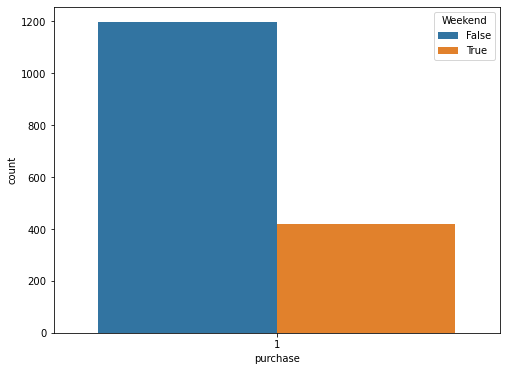

The percentage of purchases from the total data is: 15.47 %
The percentage of purchases on weekend from the total amount of purchases is: 25.85 %


In [8]:
plt.figure(figsize=(8,6))
ax =  sns.countplot(x="purchase", hue="Weekend", data=data[data["purchase"]==1])

plt.show()

purchases_total = (data[data["purchase"]==1].shape[0])
print("The percentage of purchases from the total data is:", round(purchases_total/data.shape[0],4)*100, "%")
purchases_in_weekend =  data.loc[(data['purchase'] == 1) & (data["Weekend"]==True)].shape[0]

print("The percentage of purchases on weekend from the total amount of purchases is:", round(purchases_in_weekend/purchases_total,4)*100 ,"%")
          
                 

So we see that only 25% percent are purchasing on weekends.
But the weekend is only 2 days a week and regular days are 5 days a week, so let's scale the proportion and check the precentage of purchases for a regular day and for a weekend day:

**Note**: We are assuming that the data was collected during a period of a week. if not, feel free to insert to the plot_purchase_rate function the period of time that the data was collected: "Year" or "Month", and check the differences!


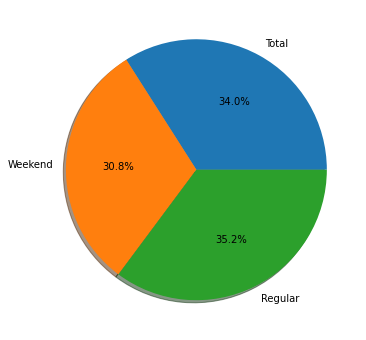

Users buy 232 products each day.
On regular days, they buy 239 products per day,
while on weekends they buy 210 products per day!



In [9]:
# scaling the data so will receive the purchases made in each day
def plot_purchase_rate(period):
    # this function plots the purchase rate per day, during regular day and weekend, depending on the period of time the data was collected 
    plt.figure(figsize=(8,6))

    if period == "Week":
        purchase_per_day_total = data.loc[(data['purchase'] == 1)].shape[0]/7
        purchase_per_day_on_weekend = purchases_in_weekend =  data.loc[(data['purchase'] == 1) & (data["Weekend"]==True)].shape[0]/2
        purchase_per_day_on_regular = purchases_in_weekend =  data.loc[(data['purchase'] == 1) & (data["Weekend"]==False)].shape[0]/5

    elif period == 'Month':
        purchase_per_day_total = data.loc[(data['purchase'] == 1)].shape[0]/30
        purchase_per_day_on_weekend = purchases_in_weekend =  data.loc[(data['purchase'] == 1) & (data["Weekend"]==True)].shape[0]/8
        purchase_per_day_on_regular = purchases_in_weekend =  data.loc[(data['purchase'] == 1) & (data["Weekend"]==False)].shape[0]/22

    elif period == 'Year':
        purchase_per_day_total = data.loc[(data['purchase'] == 1)].shape[0]/365
        purchase_per_day_on_weekend = purchases_in_weekend =  data.loc[(data['purchase'] == 1) & (data["Weekend"]==True)].shape[0]/96
        purchase_per_day_on_regular = purchases_in_weekend =  data.loc[(data['purchase'] == 1) & (data["Weekend"]==False)].shape[0]/269


    #pie chart
    x_labels= ['Total', 'Weekend', 'Regular']
    y_plot=np.array([purchase_per_day_total,purchase_per_day_on_weekend,purchase_per_day_on_regular])
    plt.pie(y_plot,labels=x_labels, shadow = True, autopct='%1.1f%%')
    plt.show()
    print("Users buy {} products each day.\nOn regular days, they buy {} products per day,\nwhile on weekends they buy {} products per day!\n".format(round(purchase_per_day_total),round(purchase_per_day_on_regular), round(purchase_per_day_on_weekend)))


plot_purchase_rate('Week')

Now let's check how the Month and the user type affect the purchase tendency.

We see that a new visitor buys more than a returning visitor! 
Also, we see that November is the month with the highest purchase rate, we assume it's related to the Black Friday and chinese singles day, which accures on November, and the probably the special sales and discounts increase the purchase rate.


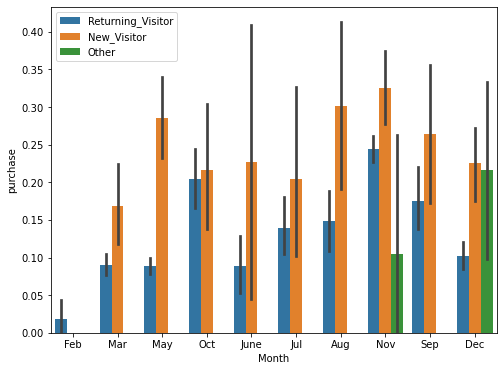

In [10]:
plt.figure(figsize=(8,6))
ax =  sns.barplot(y='purchase',x='Month',data=data,hue='user_type')
plt.legend(loc='upper left')

plt.show()

Let's explore the google analytics features to understand them better.
Previously we saw on the correlation plot that Exit rate and Bounce Rate have almost perfect correlation, which makes sense, as they both describe a leaving action, with a slight difference.
Page values, though, has a positive correlation with purchases. Let's visualise it for better understanding.

We see that the users who eventually buy, don't hesitate too much and check other options and thus the page value of this type is high, while those who don't, are exploring, taking their time, and those hesitation may cause the page value to be low.

(0.0, 100.0)

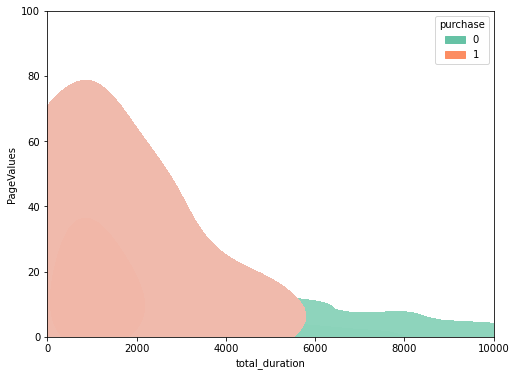

In [11]:
plt.figure(figsize=(8,6))
sns.kdeplot(x='total_duration',y='PageValues',data = data, hue='purchase', fill=True, palette="Set2")
plt.xlim(0,10000)
plt.ylim(0,100)


As for the info pages and Exit rates, we see that there's a negative correlation, meaning the more info pages users visit, the exit rate decreases, maybe because the info pages are a sign for a special interest on the site and his policies.

(0.0, 0.5)

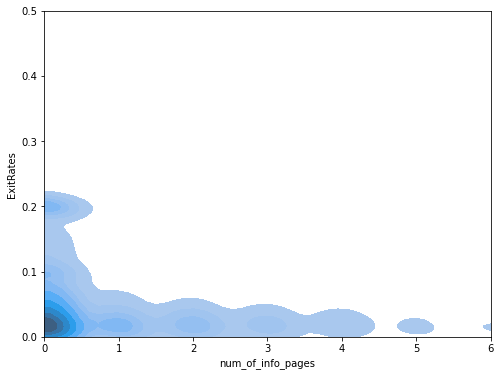

In [12]:
plt.figure(figsize=(8,6))
sns.kdeplot(x='num_of_info_pages',y='ExitRates',data=data, fill=True, palette="pastel")
plt.xlim(0,6)
plt.ylim(0,0.5)


That's an interesting one.
Returning users spend more time on each session and visit more product pages than new visitors. we expeceted it to be the opposite!
It means that maybe returning visitors are better potential customers than the new visitors, and they are deeply considering to make a purchase, while new visitors prefer to have a quick glance on the site and come back if they liked our products.

(0.0, 10000.0)

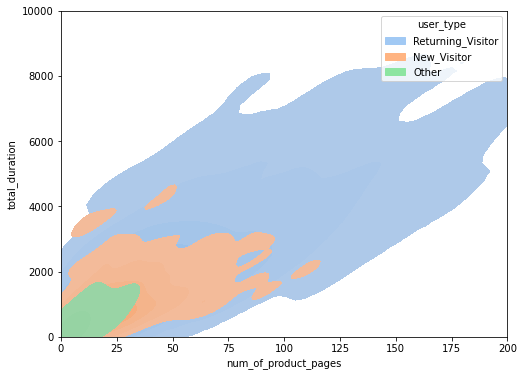

In [13]:
plt.figure(figsize=(8,6))

sns.kdeplot(x='num_of_product_pages',y='total_duration',data=data, hue='user_type', fill=True, palette="pastel" )
plt.xlim(0,200)
plt.ylim(0,10000)

Now let's explore the device/internet_browser feature. Maybe they have an effect on the purchase,
first let's see which device/internet browser is the most popular among users:


Devices:



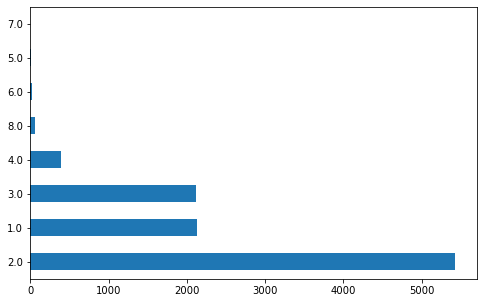


Browsers:



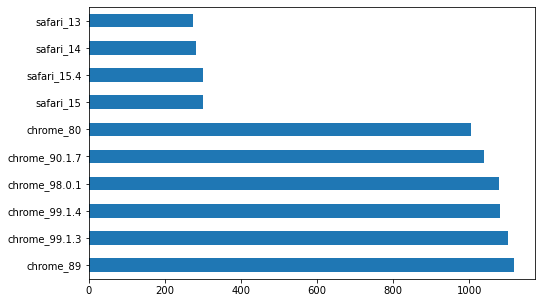

In [14]:

print("Devices:\n")
data['device'].value_counts().plot.barh(figsize=(8,5))
plt.show()

print("\nBrowsers:\n")
data['internet_browser'].value_counts()[:10].plot.barh(figsize=(8,5))
plt.show()


Devices:
So 2.0 device is the most popular, and 1 & 3 follows.
5-8 devices have unsignificant uses, so let's remove them from the plot. and now let's check which device has the best purchase rate

Browsers:
We see that there are alot of versions for the same browsers, so a smart preproccesing step would be to unite some of the values to a main one.

let's continue with the device exploration:

<AxesSubplot:>

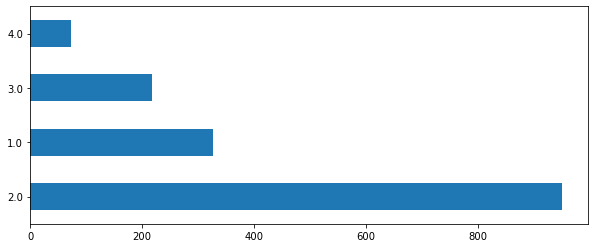

In [15]:
# filtering the unsignificant device types: 1-4
filtered_dev = data[data["device"]<5]

# Let's check the purchase count for each device type
device_purch = filtered_dev["device"].loc[filtered_dev['purchase'] == 1]
device_purch.value_counts().plot.barh(figsize=(10,4))


<AxesSubplot:>

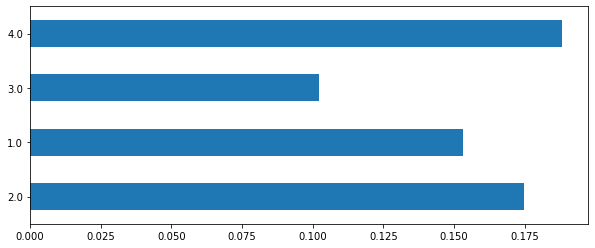

In [16]:
# For each device, let's devide the number of the devices and the number of the purchases for this device, we will receive the purchase rate
purch_rate_per_dev =device_purch.value_counts()/filtered_dev['device'].value_counts()

purch_rate_per_dev.plot.barh(figsize=(10,4))

While 2 is the most popular device, device 4 has the best purchase rate.

Let's see how the region feature distributes:

We see that all the regions have more of the same (15%) purchase rate.
It means that maybe it's just doesn't matter from which region the user is coming from, so this feature is likely to be less important for us.



<AxesSubplot:>

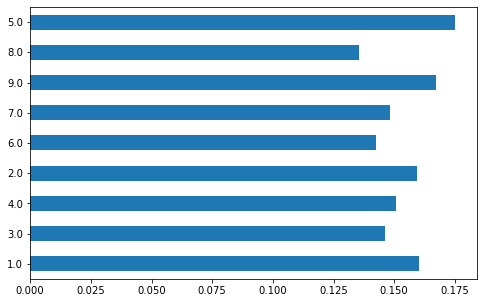

In [17]:

reg_purch = data["Region"].loc[data['purchase'] == 1]
purch_rate_per_reg =reg_purch.value_counts()/data['Region'].value_counts()
purch_rate_per_reg.plot.barh(figsize=(8,5))

# **Preproccesing:**
In order to run ML models, we will need to pre-proccess the data first, in order to work with it properly.
For example, many machine learning algorithms cannot operate on label data directly. They require all input variables and output variables to be numeric.
The pre proccesing steps include fill na values, handling outliers, handling catergorial or boolean features, and dimension reduction.
Let's start:


In [18]:
# removing id feature, it's a default pandas indexing which isn't contributing to our predictions.
data.drop('id',axis=1, inplace=True)

We want to change the durations features to float, so we can make calculations on this feature

In [19]:
data['product_page_duration'] = data['product_page_duration'].str.replace(' minutes', '').astype('float')
data['product_page_duration']

data['info_page_duration']
data['info_page_duration'] = data['info_page_duration'].str.replace(' minutes', '').astype('float')

## Handling null's
Now let's handle the Nans/missing/0's cells of the following featues:


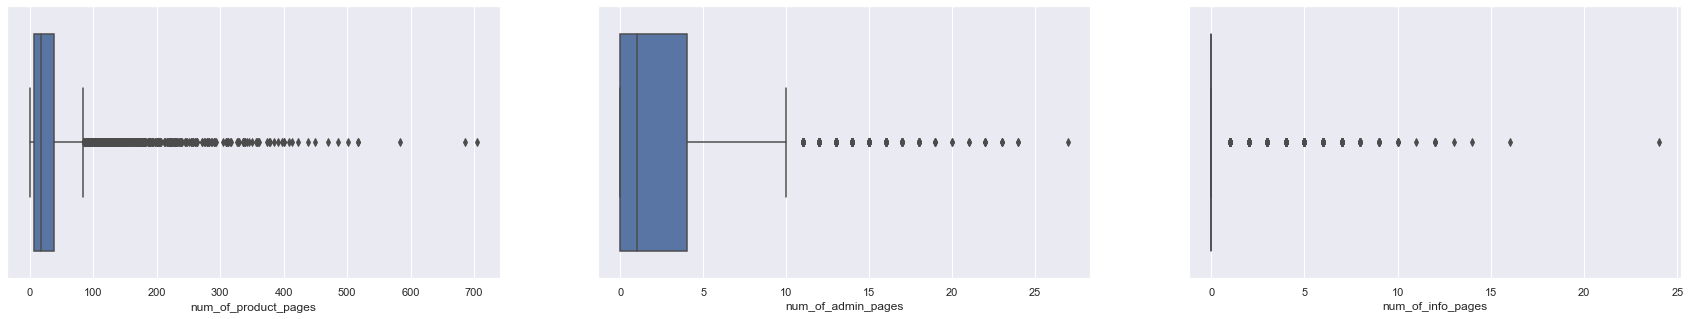

In [20]:
# plotting product/admin/info pages
sns.set(rc={'figure.figsize':(30,5)}) 
plt.subplot(131) 
sns.boxplot(data['num_of_product_pages'])

plt.subplot(132) 
sns.boxplot(data['num_of_admin_pages'])

plt.subplot(133) 
sns.boxplot(data['num_of_info_pages'])

# as we can see, there are a lot of outliers in this features, in order to get a representative value, we will choose the median as the parameter to fill it.
Orig_Med_NOPP=data['num_of_product_pages'].median()
Orig_Med_NOAP=data['num_of_admin_pages'].median()
Orig_Med_NOIP=data['num_of_info_pages'].median()
Orig_Med_APD=data['admin_page_duration'].median()
Orig_Med_IPD=data['info_page_duration'].median()
Orig_Med_PPD=data['product_page_duration'].median()

data['num_of_product_pages']= data['num_of_product_pages'].fillna(Orig_Med_NOPP)
data['num_of_admin_pages']= data['num_of_admin_pages'].fillna(Orig_Med_NOAP)
data['num_of_info_pages']= data['num_of_info_pages'].fillna(Orig_Med_NOIP)


data['admin_page_duration'] = data['admin_page_duration'].fillna(Orig_Med_APD)
data['info_page_duration'] = data['info_page_duration'].fillna(Orig_Med_IPD)
data['product_page_duration'] = data['product_page_duration'].fillna(Orig_Med_PPD)


#fill the null's of total duration by summing info+product+admin
data['total_duration']= data['total_duration'].fillna(data['admin_page_duration'] + data['info_page_duration']+data['product_page_duration'])


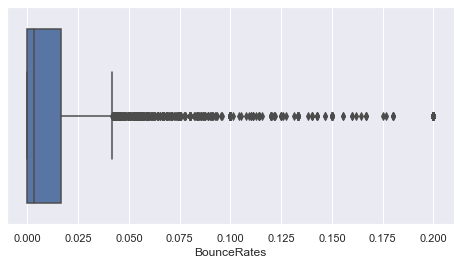

In [21]:
plt.figure(figsize=(8,4))
sns.boxplot(data['BounceRates'])

# again we see that the google analytics features have a lot of outliers, we'll choose to fill the na values with the median.
Orig_Med_BR=data['BounceRates'].median()
Orig_Med_ExR=data['ExitRates'].median()
Orig_Med_PVs=data['PageValues'].median()

data['BounceRates']= data['BounceRates'].fillna(Orig_Med_BR)
data['ExitRates']= data['ExitRates'].fillna(Orig_Med_ExR)
data['PageValues']= data['PageValues'].fillna(Orig_Med_PVs)

# Weekend feature has tiny amount of na values. We saw that the weekend sessions are quite rare, we will fill the na with false
data['Weekend']=data['Weekend'].fillna(False)

In order to handle the nulls of browser feature, we need first to merge his simillar values, such as different versions of the same browser

Browser feature unique values: ['Safari' 'Other Browsers' 'Chrome' 'Edge' nan]


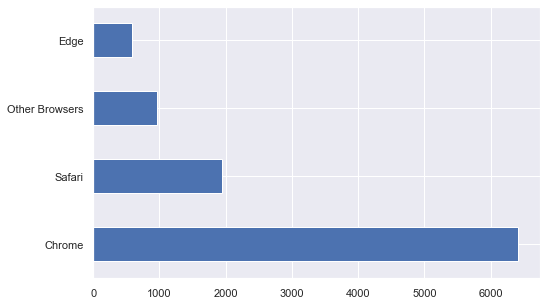

In [22]:
# Merging simillar values in the internet browser feature:
data.loc[data['internet_browser'].str.contains('Chrome',case=False,na=False), 'internet_browser'] = 'Chrome' 
data.loc[data['internet_browser'].str.contains('safari',case=False,na=False), 'internet_browser'] = 'Safari' 
data.loc[data['internet_browser'].str.contains('edge',case=False,na=False), 'internet_browser'] = 'Edge' 
data.loc[data['internet_browser'].str.contains('browser',case=False,na=False), 'internet_browser'] = 'Other Browsers' 

data['internet_browser'].value_counts().plot.barh(figsize=(8,5))
# sainity check
print("Browser feature unique values:",data['internet_browser'].unique())

In [23]:

# Fill region and month by the most common value of each feature.
Orig_Reg=data['Region'].value_counts().idxmax()
data['Region'] = data['Region'].fillna(Orig_Reg)
Orig_Month=data['Month'].value_counts().idxmax()
data['Month'] = data['Month'].fillna(Orig_Month)

# FIll the user type na by new users, we will assume that they are new as we don't know for sure that they are returning visitors.
data['user_type'] = data['user_type'].fillna('New_Visitor')

# fill closeness to holiday by the median , as most of the samples are around 0 but it isn't a normal distributed feature
Orig_Med_of_CTH=data['closeness_to_holiday'].median()
data['closeness_to_holiday'] = data['closeness_to_holiday'].fillna(Orig_Med_of_CTH)

Orig_Device_nulls=data['device'].isnull()
Orig_Device_valcount=data['device'].value_counts()
# We saw that the devices are distributes in the following way: 2.0 is the most common with half of the samples, the 1.0 and 3.0 is 25% let's fill the na's corespondelly:
print("Device na values before change:",Orig_Device_nulls.sum())
data['device'] = data['device'].fillna(Orig_Device_valcount.idxmax(),limit=int(round(Orig_Device_nulls.sum()*0.5)))
data['device'] = data['device'].fillna(Orig_Device_valcount[1:].idxmax(),limit=int(round(Orig_Device_nulls.sum()*0.5))) #half of nulls is left, we want to fill another 25%
data['device'] = data['device'].fillna(Orig_Device_valcount[2:].idxmax()) # 25% of nulls is left, we want to fill the rest 25%
print("Device na values after change:",data['device'].isnull().sum())

Orig_brows_nulls=data['internet_browser'].isnull()
Orig_brows_valcount=data['internet_browser'].value_counts()
# After ploting the internet browser feature, it distributes in the following way: chrome is the largest with 0.6 of the data, then Safari with 0.2 and Browser and Edge with 0.1
print("\nBrowser na values Before change:",data['internet_browser'].isnull().sum())

data['internet_browser'] = data['internet_browser'].fillna(Orig_brows_valcount.idxmax(),limit=int(round(Orig_brows_nulls.sum()*0.6)))
data['internet_browser'] = data['internet_browser'].fillna(Orig_brows_valcount[1:].idxmax(),limit=int(round(Orig_brows_nulls.sum()*0.5))) #40% of nulls is left, we want to fill another 20% 
data['internet_browser'] = data['internet_browser'].fillna(Orig_brows_valcount[2:].idxmax(),limit=int(round(Orig_brows_nulls.sum()*0.5))) # 20% of nulls is left, we want to fill another 10%
data['internet_browser'] = data['internet_browser'].fillna(Orig_brows_valcount[3:].idxmax()) # 10% of nulls is left, we want to fill the rest 10%
print("Browser na values After change:",data['internet_browser'].isnull().sum())


# 'B' feature is a normal distributed feature, therefore we will fill it with it's mean value
Orig_mean_B=data['B'].mean()
data['B'] = data['B'].fillna(Orig_mean_B)



Device na values before change: 323
Device na values after change: 0

Browser na values Before change: 563
Browser na values After change: 0


As for 'C' feature, we assumed that it looks like http requests, lets unite all 1XX 2XX and 8080 codes, which represents "not error"(Succes, info or proxy) to 0 and all 4XX codes which represent an error to 1
In this way we are using this feature as categorial and won't need to split him to 2 dummies later on.


In [24]:
data.loc[data['C'].str.contains('40',case=False,na=False), 'C'] = 1
data.loc[data['C'].str.contains('20|10|8080',case=False,na=False), 'C'] = 0

# now let's fill na's with success values, becuase we can assume that most of the http requests will return a non error.
data['C'] = data['C'].fillna(0)
print("'C' feature unique values:",data['C'].unique())


'C' feature unique values: [0 1]


In [25]:
# check if we finished filling all na values
data.isnull().sum()

num_of_admin_pages           0
admin_page_duration          0
num_of_info_pages            0
info_page_duration           0
num_of_product_pages         0
product_page_duration        0
total_duration               0
BounceRates                  0
ExitRates                    0
PageValues                   0
closeness_to_holiday         0
Month                        0
device                       0
internet_browser             0
Region                       0
user_type                    0
Weekend                      0
A                          706
B                            0
C                            0
D                        10374
purchase                     0
dtype: int64

We see that the 2 mysterious features 'A' and 'D' weren't handled.

As for D feature, it has too many na values and filling them would be pointless, so we will give up on it and remove it completely.

As for A, after seeing that it's a categorial feature with 97 different values, we decided that it won't help us sufficently, so we will remove it.

In [26]:
A_unique = data['A'].unique()

print("'A' feature has the following values: \n{} \n\nand it's length is: {}".format(A_unique, len(A_unique)))

data.drop(['A', 'D'], axis=1, inplace=True)

'A' feature has the following values: 
['c_1' 'c_3' 'c_4' 'c_2' nan 'c_5' 'c_6' 'c_8' 'c_10' 'c_11' 'c_9' 'c_7'
 'c_13' 'c_14' 'c_15' 'c_18' 'c_19' 'c_16' 'c_17' 'c_20_27' 'c_20_6'
 'c_20_99' 'c_20_87' 'c_20_55' 'c_20_10' 'c_20_89' 'c_20_74' 'c_20_40'
 'c_20_61' 'c_20_14' 'c_20_44' 'c_20_35' 'c_20_95' 'c_20_97' 'c_20_67'
 'c_20_71' 'c_20_39' 'c_20_22' 'c_20_9' 'c_20_58' 'c_20_19' 'c_20_82'
 'c_20_93' 'c_20_94' 'c_20_4' 'c_20_30' 'c_20_15' 'c_20_47' 'c_20_90'
 'c_20_34' 'c_20_79' 'c_20_8' 'c_20_68' 'c_20_36' 'c_20_20' 'c_20_18'
 'c_20_5' 'c_20_96' 'c_20_16' 'c_20_60' 'c_20_33' 'c_20_57' 'c_20_28'
 'c_20_38' 'c_20_66' 'c_20_43' 'c_20_75' 'c_20_53' 'c_20_11' 'c_20_51'
 'c_20_69' 'c_20_54' 'c_20_78' 'c_20_81' 'c_20_25' 'c_20_49' 'c_20_29'
 'c_20_84' 'c_20_46' 'c_20_98' 'c_20_64' 'c_20_72' 'c_20_2' 'c_20_76'
 'c_20_48' 'c_20_83' 'c_20_62' 'c_20_50' 'c_20_77' 'c_20_3' 'c_20_92'
 'c_20_37' 'c_20_88' 'c_20_65' 'c_20_63' 'c_20_80' 'c_20_23'] 

and it's length is: 97


Now after handling all na values, we can safely pre-procces categorial features.

We chose the one-hot encoding method, so in order to create features with names that we can understand, we will change features with boolean values such as Weekend to binary, this way we will use them as a categorial feature without splitting it to 2 dummies.


In [27]:
# first we would change the bool features we have to be numeric, 0 for no and 1 for yes, we will start with purchase:
data['purchase'] = data['purchase'].astype(int)


# Replace boolean to binary
data['Weekend'] = data['Weekend'].map({True: 1, False: 0})   

# sainity check
print("Weekend feature unique values:",data['Weekend'].unique())



Weekend feature unique values: [0 1]


## New Features
We see that Bounce & Exit rates are behaving the same way, and they also have extremely high correlation (0.91), We suggest to unite them and to reduce features by that.


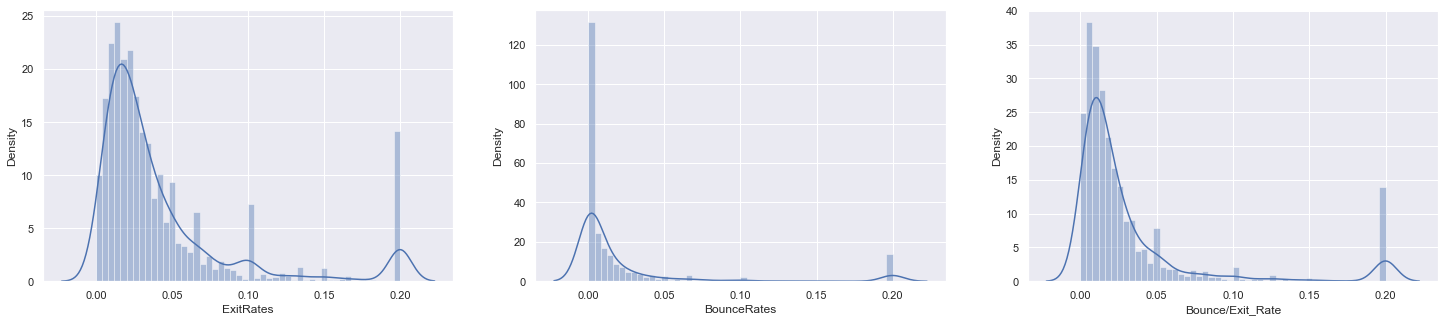

In [28]:

sns.set(rc={'figure.figsize':(25,5)}) 
plt.subplot(131) 
sns.distplot(data['ExitRates'])

plt.subplot(132) 
sns.distplot(data['BounceRates'])
data['Bounce/Exit_Rate'] = (data['BounceRates']+data['ExitRates'])/2

plt.subplot(133) 

sns.distplot(data['Bounce/Exit_Rate'])
data.drop('BounceRates' ,axis=1, inplace=True)
data.drop('ExitRates',axis=1, inplace=True)




## QQ plot
Some features histograms resembles the normal distribution, a QQ plot will help detect it.
We can see on the plots if the feature distribution (blue line) resembles the normal distribution (red line)

In [29]:
# filtering only numeric features
all_cols = data.columns
numeric_features_for_qqplot = list(data.select_dtypes(include=[np.number]).columns)
remove_features = ['device', 'Region', 'purchase','Weekend', 'C'] # Categoiral features with numeric values, we want to avoid them
numeric_features_for_qqplot = [feat for feat in numeric_features_for_qqplot if feat not in remove_features]
numeric_features_for_qqplot

['num_of_admin_pages',
 'admin_page_duration',
 'num_of_info_pages',
 'info_page_duration',
 'num_of_product_pages',
 'product_page_duration',
 'total_duration',
 'PageValues',
 'closeness_to_holiday',
 'B',
 'Bounce/Exit_Rate']

<Figure size 1800x360 with 0 Axes>

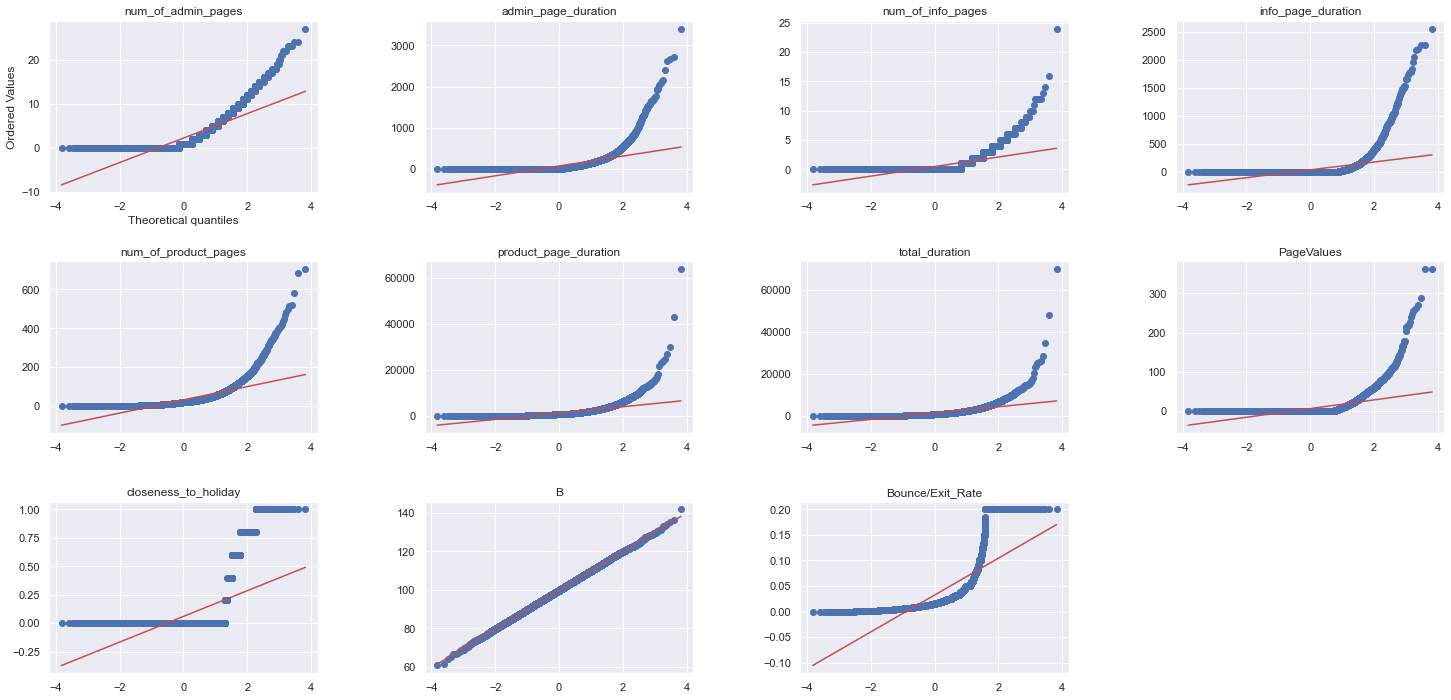

In [30]:
fig =plt.figure()
plt.figure(figsize=(25,12))
# creating a sublot for each feature
i=1
for feature in numeric_features_for_qqplot:
  plt.subplot(3, 4, i)
  stats.probplot(data[numeric_features_for_qqplot[i-1]], dist="norm", plot=plt)
  plt.title(numeric_features_for_qqplot[i-1])
  plt.xlabel=([])
  plt.ylabel=([])

  if i<=len(numeric_features_for_qqplot)-1:  # condition to avoid index out of range
    i+=1

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()


In [31]:
# from this plotting, we decided that the features that distributes normally are:
Norm_feat= ['product_page_duration','total_duration','B']

# saving normal feautures mean and std for test pre processing
Norm_feat_mean = [data[feat].mean() for feat in Norm_feat]
Norm_feat_std = [data[feat].std() for feat in Norm_feat]
# The other features will be marked as minmax, that's for the normalization part
MinMax_feat=['PageValues', 'Bounce/Exit_Rate','closeness_to_holiday', 'admin_page_duration',
             'num_of_product_pages','num_of_info_pages', 'num_of_admin_pages', 'info_page_duration'] 

# saving the original columns of minmax list for the test data preproccesing, so we won't make the same action on a feature twice
minmax_features_copy= data[MinMax_feat].copy(deep=True)


## Handling Outliers
The outliers in data is a potential for problems in our model, as we are willing to train the data on the samples that represent it the most, and not by exceptional samples. That's why we will remove some outliers by the following methods:
 
Let's start with the features who doesn't distribute normally. We will plot them and see how do they behave.

Num of info & admin & prodcut pages:
Most of the samples are on 0, and a few is higher

<AxesSubplot:xlabel='num_of_info_pages'>

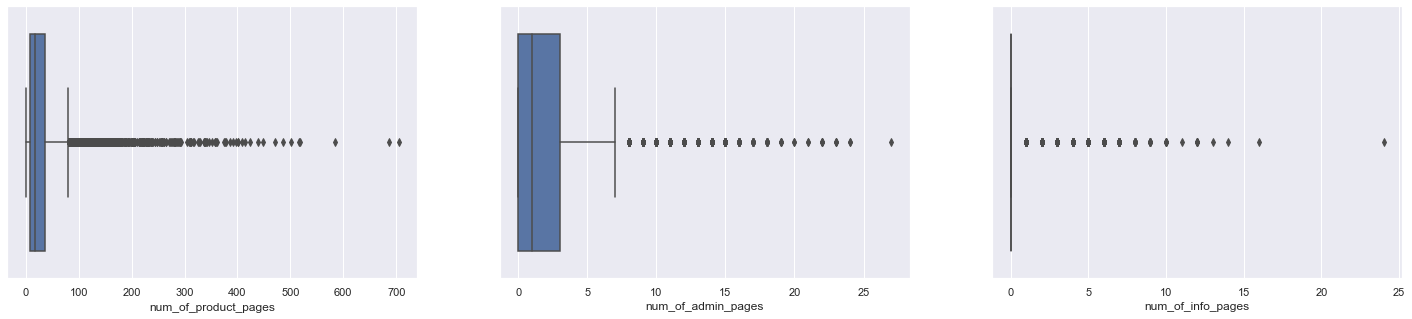

In [32]:
sns.set(rc={'figure.figsize':(25,5)}) 
plt.subplot(131) 
sns.boxplot(data['num_of_product_pages'])

plt.subplot(132) 
sns.boxplot(data['num_of_admin_pages'])

plt.subplot(133) 
sns.boxplot(data['num_of_info_pages'])

<AxesSubplot:xlabel='num_of_info_pages'>

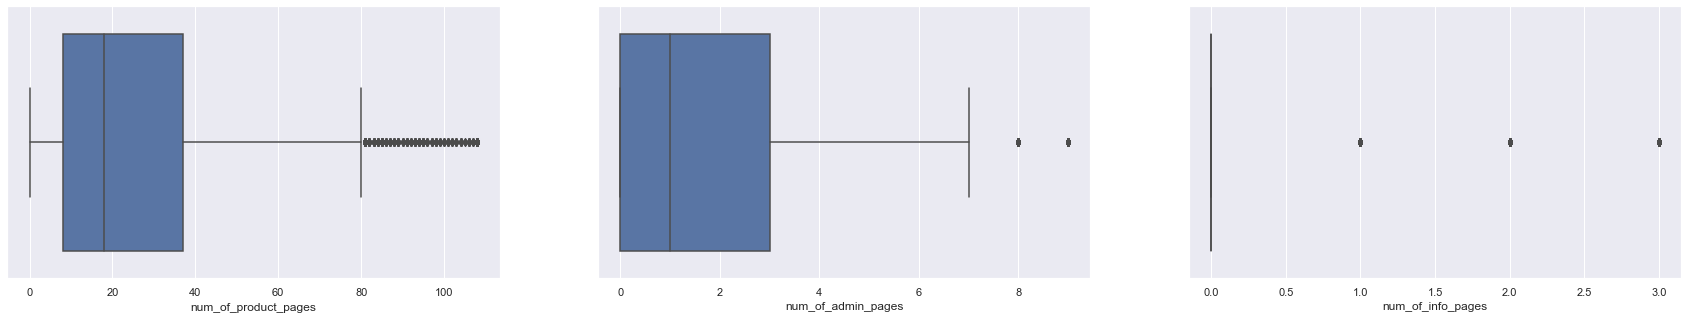

In [33]:
# As we can see those features have skewed samples, therefore, but we want to handle the outliers carefully, as we don't want to lose samples.
# Winsorization is the process of replacing the extreme values of statistical data in order to limit the effect of the outliers on the calculations or the results obtained by using that data.
# We would use the winsorize function to normilze the outliers to the 95% percentage upper limit. The lower limit will remain 0 and we don't want to cut from it, as most of the data in these features placed there!

tmp_list = ['product', 'admin', 'info']
outliers_dic = {}
for i in tmp_list:
  outliers_dic['transformed_{}_data'.format(i)] = pd.Series(winsorize(data['num_of_{}_pages'.format(i)], limits=[0.0, 0.05]))   
  data['num_of_{}_pages'.format(i)] = outliers_dic['transformed_{}_data'.format(i)]
  
sns.set(rc={'figure.figsize':(30,5)}) 

plt.subplot(131) 
sns.boxplot(data['num_of_product_pages'])

plt.subplot(132) 
sns.boxplot(data['num_of_admin_pages'])

plt.subplot(133) 
sns.boxplot(data['num_of_info_pages'])




Looks way better! Let's continue with the other 5 features remaining: 
'Bounce/Exit_Rate','closeness_to_holiday', 'info_page_duration', 'PageValues', 'admin_page_duration'.

<AxesSubplot:xlabel='PageValues', ylabel='Density'>

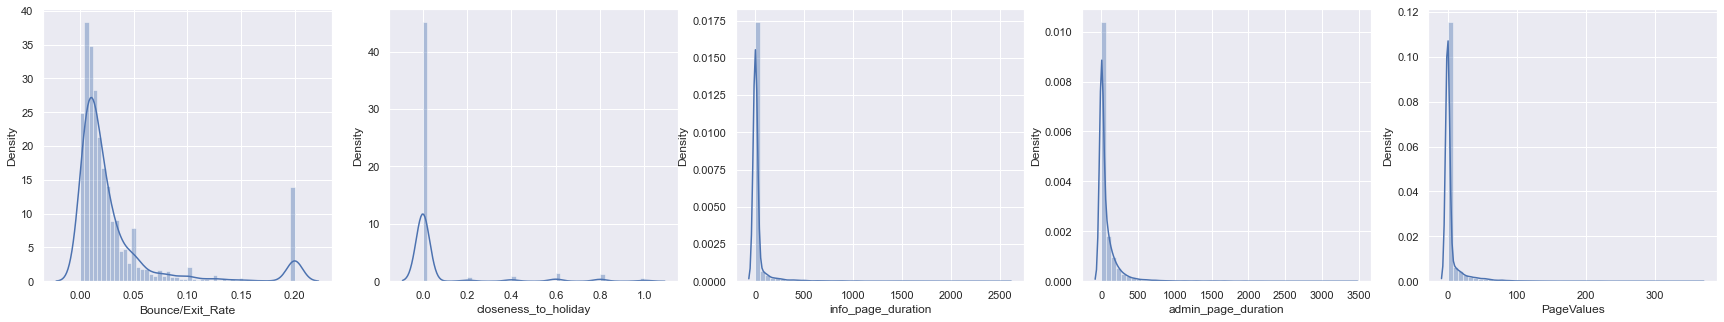

In [34]:

sns.set(rc={'figure.figsize':(30,5)}) 
plt.subplot(151) 
sns.distplot(data['Bounce/Exit_Rate'])

plt.subplot(152) 
sns.distplot(data['closeness_to_holiday'])

plt.subplot(153) 
sns.distplot(data['info_page_duration'])

plt.subplot(154) 
sns.distplot(data['admin_page_duration'])

plt.subplot(155) 
sns.distplot(data['PageValues'])


We see that every feature in this section distributes more of the same excpet Bounce/Exit Rates.

Let's use again the winsorize for the 4 same distributed features to set a upper limit of 95% to fill the outliers.

About Bounce/Exit_Rate, We see 2 main gaugasians, so we will keep him this way, as setting upper limit will corrupt the data for this feature.

In [35]:
data['info_page_duration']= winsorize(data['info_page_duration'], limits=[0, 0.05])

data['admin_page_duration']= winsorize(data['admin_page_duration'], limits=[0, 0.05])

data['PageValues']= winsorize(data['PageValues'], limits=[0, 0.05])

data['closeness_to_holiday']= winsorize(data['closeness_to_holiday'], limits=[0, 0.05])


Now we will continue handling the normally distributed features.
Becuase we already saw in the qqplot that they are normally distributed, we want to normalize the outliers.
We will define an outlier threshold value (generally 3.0 sigmas), each value that excceeds this limit from each side, will be set to the bound we calculated.

For 'B' feature, we saw it has perfect normal distribution, so cutting outliers isn't necessary in this case. 


In [36]:
threshold = 3
# setting an upper and lower boundery to the normal distributed features, and setting the outliers to these boundries
for feat in [feat for feat in Norm_feat if feat is not 'B']:
  mean = data[feat].mean()
  std = data[feat].std()
  bnd = std * threshold
  l_bnd = mean- bnd
  u_bnd = mean + bnd
  data.loc[data[feat] < l_bnd, feat] = l_bnd
  data.loc[data[feat] > u_bnd, feat] = u_bnd



## **Get Dummies to transform Categorical Variables**
We would like to handle our categorial features!
We chose the dummies one how encoding method as we believe it would be the most efficent, and we think the the dimension reduction will reduce the huge amount of features we will create.
On this part, we decided to give up on device and region features, because of the conclusions we mentioned in the exploration part: the region and device type do not affect sufficently on the purchase rate.

In addition, after running SelectKBest algorithm with mutual info classifier that will be executed up ahead, these features and their dummies haven't been chosen.

In [37]:
# splitting the 5 categorial features into dummies
Set1= pd.get_dummies(data['Month'])
Set2=pd.get_dummies(data['internet_browser'])
Set3=pd.get_dummies(data['user_type'])

# merge them to our data
frames=[data,Set1,Set2,Set3]
merged=pd.concat(frames,axis='columns')

# dropping the old columns before encoding, and also the region and device columns we decided to disclude from our models. 
FixedData=merged.drop(['internet_browser','Month', 'user_type','Region','device'],axis='columns')
print("New Shape of our data after adding Categorials: " , FixedData.shape)

# sainity check
FixedData.head(10)


New Shape of our data after adding Categorials:  (10479, 31)


,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,PageValues,closeness_to_holiday,Weekend,B,C,purchase,Bounce/Exit_Rate,Aug,Dec,Feb,Jul,June,Mar,May,Nov,Oct,Sep,Chrome,Edge,Other Browsers,Safari,New_Visitor,Other,Returning_Visitor
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0,118.880094,0,0,0.200000,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0,113.358423,1,0,0.200000,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,0.0,0.0,0.0,0.0,18.0,627.500000,627.500000,0.0,0.0,1,121.507695,0,0,0.035000,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,0.0,0.0,0.0,0.0,19.0,154.216667,154.216667,0.0,0.0,0,93.747176,0,0,0.020175,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.4,0,99.545824,0,0,0.200000,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
5,0.0,0.0,0.0,0.0,2.0,598.441667,598.441667,0.0,0.6,0,104.712405,0,0,0.050000,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
6,0.0,0.0,0.0,0.0,3.0,738.000000,738.000000,0.0,0.4,0,89.786568,1,0,0.011111,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
7,0.0,0.0,0.0,0.0,3.0,395.000000,395.000000,0.0,0.0,0,101.184534,0,0,0.033333,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
8,1.0,0.0,0.0,0.0,16.0,407.750000,407.750000,0.0,0.4,0,83.931739,0,0,0.022292,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
9,0.0,0.0,0.0,0.0,7.0,280.500000,280.500000,0.0,0.0,0,97.899633,0,0,0.014286,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1


## Test data Normalization
Before starting to reduce dimensions, We want to normalize the data. In general, we saw that the data isn't normalized, as it has different ranges, and different scales. We want to make the data consistent and to prevent unwanted effects because of these differences!
Let's normalize it based on the qq plot we saw earlier:
For normal distributed data we will use StandardScaler, to make the same mean and variance.
For the other numeric features, we will use the MinMaxScaler, as this method fits these features the most. 

In [38]:
standard = StandardScaler()
minmax = MinMaxScaler()
FixedData[Norm_feat] = standard.fit_transform(FixedData[Norm_feat])
FixedData[MinMax_feat] = minmax.fit_transform(FixedData[MinMax_feat])


## Train/Test Data split

In [39]:
y=FixedData['purchase']
X= FixedData.drop('purchase',axis='columns')
print(f'X.shape: {X.shape}, y.shape: {y.shape}')

#split to train and test
X_train_raw ,X_val_raw ,y_train, y_val = train_test_split(X,y,test_size = 0.2, random_state= 0, shuffle=True)
print(f'X_train: {X_train_raw.shape}, y_train.shape: {y_train.shape}, \
X_Validation_raw.shape: {X_val_raw.shape}, y_Validation.shape: {y_val.shape}')



X.shape: (10479, 30), y.shape: (10479,)
X_train: (8383, 30), y_train.shape: (8383,), X_Validation_raw.shape: (2096, 30), y_Validation.shape: (2096,)


## Dimensionality Reduction:
Now after removing the most signifcant outliers in the data, we can think how to reduce the dimension of the data based on the knowledge we gained until now.

We see that there are 23 features in this dataset, and by adding our categorial dummy features, we increased it to 30. This amount of featrues will probably cause the each sample to be more unique, and increases the variance of the data. We would like to have a sufficent amount of dimensions, to make the model not too robust and not too flexible, and to let him predict the new examples properly, and not to train him for each unique example, which would defnitely case over fitting. This amount of features would also have computational costs, that we would like to save as much as we can.
We can also see that currently we have 7 additional features which we added, and also identified features with high correlation between them (Bounce & Exit rates). As a result we are suspecting that we have too many dimensions in our data.
In order to identify whether there are too dimensions, we can make use PCA to see how many features are needed to preserve most of the explained variance. So we would like to reduce the amount of features, and remove unhelpful featues:



### PCA
We want to understand how many features we can reduct and still to preserve a decent amount of explained variance in our data. We chose PCA because it is a simple and quite precise method to do it.

Instead of determining a fixed amount of features, we let the PCA to decide 
how many features will preserve 99% of the explained variance. 

**Note**:
After reading few articles about PCA and one hot encoding, we decided to remove the dummy features from the PCA calculation, as we understod that by applying PCA on data with one hot enconding we gain nothing, but creating a more complicated rotation of our binary data. [link to the article](https://andrewpwheeler.com/2021/06/22/pca-does-not-make-sense-after-one-hot-encoding/)


In [40]:
# select numeric features for reduction
X_train_raw_for_pca = [feature for feature in X_train_raw if feature in numeric_features_for_qqplot]

print(X_train_raw_for_pca)



['num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages', 'info_page_duration', 'num_of_product_pages', 'product_page_duration', 'total_duration', 'PageValues', 'closeness_to_holiday', 'B', 'Bounce/Exit_Rate']


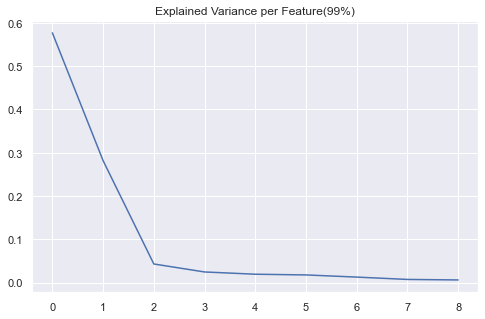

number of components which preserve at least 99% of the variance: 9


In [41]:
# this function receives a numpy array and the precentage of explained variance we want to preserve, and outputs the amount of features that will preserve it.
def get_principal_components(X: np.array, p: float) -> np.array:

    pca = PCA(n_components = p, svd_solver='full')
    pca.fit(X)
    X_new = pca.transform(X)
    Comp = pca.components_ 
    
    plt.figure(figsize = (8,5))
    plt.plot(pca.explained_variance_ratio_)
    plt.title("Explained Variance per Feature(99%)")
    plt.show()
    return Comp


components = get_principal_components(X_train_raw[X_train_raw_for_pca],0.99)

print(f'number of components which preserve at least 99% of the variance: {len(components)}')


We understand that we should pass 9 features!

We won't use the 9-dimensioned data that the PCA provided, as each feature is al linear combination of the original features, and it won't help us business-wise, as we can't make any manipulations to the features and the values have no meaning. 

On the other hand, the PCA did help us, by providing the amount of features to choose: 9
For choosing which features are the most critical, we will use the mutual info classifier, which looks for a measurable connection between a feature and the label- meaning it measures the entropy drops under the condition of the target value.

In [42]:
# selecting 9 best features
np.random.seed(0) # to get the same results each time
selector = SelectKBest(mutual_info_classif, k=9)
X_reduced = selector.fit_transform(X_train_raw, y_train)

cols = selector.get_support(indices=True)
selected_columns = X_train_raw.iloc[:,cols].columns.tolist()

model_features = selected_columns

print("The features we selected to run the model with:\n" ,model_features)

The features we selected to run the model with:
 ['num_of_admin_pages', 'admin_page_duration', 'num_of_product_pages', 'product_page_duration', 'total_duration', 'PageValues', 'closeness_to_holiday', 'Bounce/Exit_Rate', 'Nov']


### Forward Selection
we chose forward stepwise selection, as it can used when the number of variables under consideration is very large.

However, we didn't use it eventually as it gave us poor results on our models.
The reason we didn't choose it is that we found that the mallow cp score and MSE calculation isn't helful when it comes to classification, therfore we eventually chose the PCA

In [43]:
####### Forward selection try- wasn't used eventually##############

import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)         # Because we set xlabel and ylabel before as list (on the qqplot) we need to reload the plt so the function would work


def get_sigma_hat_squared(X: np.array, y: np.array) -> float:
    """
    Returns sigma_hat squared - an estimate of the noise variance sigma
    X: 2d np.array with the data.
    y: labels
    return: float - the sigma hat squared.
    """
    reg  = LinearRegression()
    reg.fit(X,y)
    RSS = mean_squared_error(y,reg.predict(X)) * len(y)
    return ((1/(len(y)-X.shape[1]-1) * RSS))

def get_mallows_cp_score(X: np.array ,y: np.array, sigma_hat_squared: float) -> float:
    """
    Returns mallow cp score for given data, selected features and train model.
    X: 2d numpy array of data with only selected features
    y: 1d numpy array of labels (also knows as target values)
    sigma_hat_squared: the estimate for noise variance
    """

    reg  = LinearRegression()
    reg.fit(X,y)
    MSE = mean_squared_error(y,reg.predict(X))
    d = X.shape[1]
    score = MSE + (2*(d+1)/len(y)) * sigma_hat_squared
    return score
    
def add_feature(X: np.array ,y: np.array ,current_features: List[int] , sigma_hat_squared: float) -> Dict:
    """
    Returns dictionary with list of features including chosen feature to include and the score with selected feature
    X: 2d np array with all the features.
    y: 1d np array with the labels
    current_features: list of indexes which represent the features which are already included
    sigma_hat_squared: the estimate for noise variance
    returns: A dictionary with 2 keys:
            'features': a sorted list of indexes containing the features of the best model (with the additional feature) -> current_features + [added feature]
            'score': the mallows cp score of that model
    """
    best_features_lst = [] 
    best_score = np.inf
    
    
    for i in range(X.shape[1]):
        if i in current_features:
            continue
        
        else:
            tmp_f_lst = current_features.copy()
            tmp_f_lst.append(i)
            masked_X = X[:, tmp_f_lst] 
            tmp_score = get_mallows_cp_score(masked_X, y, sigma_hat_squared)
            
            if tmp_score < best_score:
                best_score = tmp_score
                best_features_lst = tmp_f_lst
    
    if X.shape[1]==len(current_features):
        tmp_score = get_mallows_cp_score(X, y, sigma_hat_squared)     
        if tmp_score < best_score:
                best_score = tmp_score
                best_features_lst = current_features
    

    return {'features':sorted(best_features_lst),'score':best_score}  

def forward_selection(X: np.array, y: np.array) -> List[int]:
    NumberOfFeatures = X.shape[1]
    current_features = []
    # Calculate error on model with all features
    sigma_hat_squared = get_sigma_hat_squared(X, y)

    models_lst = []
    for i in range(NumberOfFeatures):
        res = add_feature(X,y,current_features,sigma_hat_squared)
        models_lst.append(res)
        current_features = models_lst[-1]['features']
    
    #Plotting
    plt.figure(figsize=(8,5))
    scores_lst = [x['score'] for x in models_lst]
    plt.plot(range(1,len(scores_lst)+1),scores_lst)
    plt.xlabel("number of features")
    plt.ylabel("Mallows cp")
    plt.title("Mallows Cp score VS number of features")
    plt.show()

    #Returning features of best model, based on mcp score
    best_model = min(models_lst, key = lambda x: x['score'])
    best_features = best_model['features']
    return sorted(best_features)

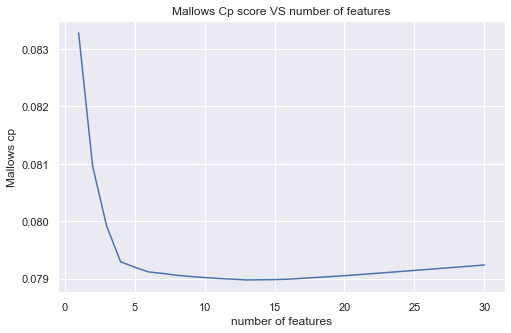

number of selected features by forward: 13


In [44]:
res = forward_selection(X_train_raw.to_numpy(), y_train.to_numpy())
print(f'number of selected features by forward: {len(res)}')
####### Forward selection try- wasn't used eventually##############


## Preproccess on test data

In [45]:
# load test dataset
data_test = pd.read_csv("test.csv")
pd.set_option('display.max_columns', None)

In [46]:
#How many features has null value??
print(data_test.isnull().sum())

print(data_test.shape)

id                          0
num_of_admin_pages         93
admin_page_duration        78
num_of_info_pages         126
info_page_duration         64
num_of_product_pages       77
product_page_duration     113
total_duration            844
BounceRates                 4
ExitRates                   2
PageValues                  2
closeness_to_holiday       87
Month                       3
device                     64
internet_browser          107
Region                      2
user_type                   2
Weekend                     2
A                         121
B                           2
C                           1
D                        1832
dtype: int64
(1851, 22)


In [47]:
# converting the duration features to int:
data_test['product_page_duration'] = data_test['product_page_duration'].str.replace(' minutes', '').astype('float')
data_test['info_page_duration'] = data_test['info_page_duration'].str.replace(' minutes', '').astype('float')

### Handling nulls in the data set


In [48]:
# this features will be filled with the mean and median of the train data as in real life, we aren't aware of the statistical attributes of the test.

data_test['num_of_admin_pages']= data_test['num_of_admin_pages'].fillna(Orig_Med_NOAP)
data_test['admin_page_duration'] = data_test['admin_page_duration'].fillna(Orig_Med_APD)
data_test['info_page_duration'] = data_test['info_page_duration'].fillna(Orig_Med_IPD)
data_test['num_of_product_pages']= data_test['num_of_product_pages'].fillna(Orig_Med_NOPP)
data_test['product_page_duration'] = data_test['product_page_duration'].fillna(Orig_Med_PPD)
data_test['num_of_info_pages']= data_test['num_of_info_pages'].fillna(Orig_Med_NOIP)

data_test['BounceRates']= data_test['BounceRates'].fillna(Orig_Med_BR)
data_test['ExitRates']= data_test['ExitRates'].fillna(Orig_Med_ExR)
data_test['PageValues']= data_test['PageValues'].fillna(Orig_Med_PVs)

data_test['closeness_to_holiday'] = data_test['closeness_to_holiday'].fillna(Orig_Med_of_CTH)

data_test['B'] = data_test['B'].fillna(Orig_mean_B)

# fill the null's of total duration by summing info + product + admin
data_test['total_duration']= data_test['total_duration'].fillna(data_test['admin_page_duration'] + data_test['info_page_duration']
                                                                +data_test['product_page_duration'])

# fill the month nulls with the most common value for each feature, based on the train data.
data_test['Month'] = data_test['Month'].fillna(Orig_Month)

# fill the weekend nulls with false, as based on the train data, it's likely that the session occured on a regular day
data_test['Weekend']=data_test['Weekend'].fillna(False)

### Handling categorial features

In [49]:
# fill the user type na by new users, we will assume that they are new as we don't know for sure that they are returning
data_test['user_type'] = data_test['user_type'].fillna('New_Visitor')


# Merging simillar values in the internet browser feature:
data_test.loc[data_test['internet_browser'].str.contains('Chrome',case=False,na=False), 'internet_browser'] = 'Chrome' 
data_test.loc[data_test['internet_browser'].str.contains('safari',case=False,na=False), 'internet_browser'] = 'Safari' 
data_test.loc[data_test['internet_browser'].str.contains('edge',case=False,na=False), 'internet_browser'] = 'Edge' 
data_test.loc[data_test['internet_browser'].str.contains('browser',case=False,na=False), 'internet_browser'] = 'Other Browsers' 

# sainity check
print("Browser feature unique values:",data_test['internet_browser'].unique())

#fill the browser nulls with the distribution of the train data: chrome is the largest with 0.6 of the data, then Safari with 0.2 and Browser and Edge with 0.1
print("\nBrowser na values Before change (in data test):",data_test['internet_browser'].isnull().sum())
data_test['internet_browser'] = data_test['internet_browser'].fillna(Orig_brows_valcount.idxmax(),limit=int(round(Orig_brows_nulls.sum()*0.6)))
data_test['internet_browser'] = data_test['internet_browser'].fillna(Orig_brows_valcount[1:].idxmax(),limit=int(round(Orig_brows_nulls.sum()*0.5))) #40% of nulls is left, we want to fill another 20% 
data_test['internet_browser'] = data_test['internet_browser'].fillna(Orig_brows_valcount[2:].idxmax(),limit=int(round(Orig_brows_nulls.sum()*0.5))) # 20% of nulls is left, we want to fill another 10%
data_test['internet_browser'] = data_test['internet_browser'].fillna(Orig_brows_valcount[3:].idxmax()) # 10% of nulls is left, we want to fill the rest 10%
print("Browser na values After change (in data test):",data_test['internet_browser'].isnull().sum())



Browser feature unique values: ['Chrome' 'Other Browsers' 'Safari' 'Edge' nan]

Browser na values Before change (in data test): 107
Browser na values After change (in data test): 0


In [50]:

# Replace boolean to binary
data_test['Weekend'] = data_test['Weekend'].map({True: 1, False: 0})      

# handling the 'C' feature: We would like to set binary representation, of 1 as an error, and 0 as no error
data_test.loc[data_test['C'].str.contains('40',case=False,na=False), 'C'] = 1
data_test.loc[data_test['C'].str.contains('20|10|8080',case=False,na=False), 'C'] = 0

# fill 'C' nulls with success values, becuase we can assume that most of the http requests will return a non error.
data_test['C'] = data_test['C'].fillna(0)
data_test['C'].unique()


array([0, 1], dtype=int64)

In [51]:
## New Features to the test set
data_test['Bounce/Exit_Rate'] = (data_test['BounceRates']+data_test['ExitRates'])/2


In [52]:
# drop unnecessary columns
data_test.drop('BounceRates' ,axis=1, inplace=True)
data_test.drop('ExitRates',axis=1, inplace=True)
data_test.drop(['A', 'D'], axis=1, inplace=True)

### Handling outliers  

In [53]:
# handling outliers in normal distributed features (except 'B' that we is perfect noramlized so no outliers removal is required)
threshold = 3
i = 0
for feat in [feat for feat in Norm_feat if feat is not 'B']:
  mean = Norm_feat_mean[i]
  std = Norm_feat_std[i]
  bnd = std * threshold
  l_bnd = mean- bnd
  u_bnd = mean + bnd
  data_test.loc[data_test[feat] < l_bnd, feat] = l_bnd
  data_test.loc[data_test[feat] > u_bnd, feat] = u_bnd
  i += 1


In [54]:
# handling outliers of non normal distributed features: by winsorizing. Bounce/Exit Rates feature is skipped becuase of his unique distribution and in order not to corrupt it. 
tmp_list = ['product', 'admin', 'info']
outliers_dic = {}
for i in tmp_list:
  outliers_dic['transformed_{}_data'.format(i)] = pd.Series(winsorize(minmax_features_copy['num_of_{}_pages'.format(i)], limits=[0.0, 0.05]))   
  data_test['num_of_{}_pages'.format(i)] = outliers_dic['transformed_{}_data'.format(i)]

data_test['info_page_duration']= pd.Series(winsorize(minmax_features_copy['info_page_duration'], limits=[0, 0.05]))

data_test['admin_page_duration']= pd.Series(winsorize(minmax_features_copy['admin_page_duration'], limits=[0, 0.05]))

data_test['PageValues']= pd.Series(winsorize(minmax_features_copy['PageValues'], limits=[0, 0.05]))

data_test['closeness_to_holiday']= pd.Series(winsorize(minmax_features_copy['closeness_to_holiday'], limits=[0, 0.05]))


### Dummies to categorial features

In [55]:
print("Shape of our data Before adding Categorials: " , data_test.shape)  
Set_of_Month_TEST= pd.get_dummies(data_test['Month'])
Set_of_User_Type_TEST=pd.get_dummies(data_test['user_type'])
Set_of_Brows_TEST=pd.get_dummies(data_test['internet_browser'])

Curr_frames=[data_test,Set_of_Month_TEST,Set_of_User_Type_TEST,Set_of_Brows_TEST]
Curr_merged=pd.concat(Curr_frames,axis='columns')

Fixed_Test_Data=Curr_merged.drop(['id','internet_browser','Month', 'user_type','Region','device'],axis='columns')
               
print("New Shape after adding Categorials to test data: " , Fixed_Test_Data.shape)


Shape of our data Before adding Categorials:  (1851, 19)
New Shape after adding Categorials to test data:  (1851, 30)


### Test data normalization


In [56]:
standard = StandardScaler()
minmax = MinMaxScaler()

Fixed_Test_Data[Norm_feat] = standard.fit_transform(Fixed_Test_Data[Norm_feat])
Fixed_Test_Data[MinMax_feat] = minmax.fit_transform(Fixed_Test_Data[MinMax_feat])


## Final selection for submission

In [57]:
data_for_submmission = Fixed_Test_Data[model_features]

# sainity check
data_for_submmission.head(-10)


,num_of_admin_pages,admin_page_duration,num_of_product_pages,product_page_duration,total_duration,PageValues,closeness_to_holiday,Bounce/Exit_Rate,Nov
0,0.000000,0.000000,0.009259,-0.749384,-0.773870,0.000000,0.000000,0.250000,0
1,0.000000,0.000000,0.009259,-0.793036,-0.813750,0.000000,0.000000,0.475000,0
2,0.000000,0.000000,0.166667,-0.369012,-0.815483,0.000000,0.000000,1.000000,0
3,0.000000,0.000000,0.175926,-0.772159,-0.794677,0.000000,0.000000,0.250000,0
4,0.000000,0.000000,0.009259,-0.750096,-0.774520,0.000000,0.666667,0.125000,0
...,...,...,...,...,...,...,...,...,...
1836,0.000000,0.000000,0.166667,0.166069,0.137886,0.000000,1.000000,0.091935,0
1837,0.222222,0.428731,0.231481,-0.369012,-0.546515,0.000000,0.000000,0.118056,0
1838,0.111111,0.017864,0.416667,0.121654,0.092433,0.000000,0.000000,0.077260,0
1839,0.000000,0.000000,0.046296,2.243739,2.446396,0.000000,0.000000,0.046388,1


# Models
We chose the following models for the project:
Logisitic regression,
KNN,
Random Forest,
SVM

We used Gridsearch function to evalute the infulence of few hyperparameters on the score, but we chose to represent in this project only part of the different combinations, due to runtime consideration.

### **Model Selection with K-Fold Cross Validation**
First things first, let's create a function that will make a K-fold cross validation, provide us the roc auc score of validation/train data, and visualize the results with a nice plot. 

In [58]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)         # Because we set xlabel and ylabel before as list (on the qqplot) we need to reload the plt so the function would work

# The function creates a k-fold cross validation for the input, and plots the ROC Curve of every fold. in addition it prints the AUC score for test data, and if Train=True also to the train data. 
def Kfold_plot_auc(X, y, clf, k, Train = False):
    
    plt.figure(figsize=(5,5))
    # Creating folds based on the k we inserted as input.
    kf = KFold(n_splits=k) 
    kf.get_n_splits(X)
    splits = kf.split(X)
    
    # sum of tpr and fpr
    sum_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    
    # spliting the data to train and test for each fold
    i = 1
    for train_idx, test_idx in splits:
        X_train, X_test = X.take(list(train_idx),axis=0), X.take(list(test_idx),axis=0)
        y_train, y_test = y.take(list(train_idx),axis=0), y.take(list(test_idx),axis=0)
        
        # training the model
        clf.fit(X_train, y_train)

        # predicting the probabilty of test/train, based on condition (Train=True)
        if Train:
          y_prob = clf.predict_proba(X_train)[:,1]
          fpr, tpr, thresholds = roc_curve(y_train, y_prob)
        
        else:
          y_prob = clf.predict_proba(X_test)[:,1]
          fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        
        # plotting the roc curve   
        single_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='cyan') #The ROC curve of the train
        i += 1
        # sum for mean 
        sum_tpr += interp(mean_fpr, fpr, tpr)
        sum_tpr[0] = 0.0

       # after all folds have finished, devide the tpr by k to get the mean tpr
    mean_tpr = sum_tpr / k
    mean_tpr[-1] = 1.0 
    mean_auc = auc(mean_fpr, mean_tpr)

    # print results
    if Train:
      print('\nTrain AUC:', round(mean_auc, 3))
    
    else:
      print('\nValidation AUC:', round(mean_auc, 3))
    # plot 0.5 line (random choice)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    
    # mean roc curve plot
    plt.plot(mean_fpr, mean_tpr, color='red', linestyle = '-', label = 'Mean ROC (auc= {})'.format(round(mean_auc,3)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    leg = plt.legend(loc="lower right",frameon = True, shadow = True, fontsize = 'medium')
    plt.title('{} ROC Curve'.format(type(clf).__name__))
    plt.show()




## Logistic Regression


Before running this model we performed a Gridserach, which recommended us to set the C hyperparameter to 0.1 which causes more regularization, meaning that we the model gave more weight to this complexity penalty at the expense of fitting to the training data.

However, if changing the C to a higher value, doesn't effect the roc score, so we changed it to 10 to get less regularization.

We can see that running this function with the following params, gave us nice results, which we can see that aren't overfitted at all (we see it by comparing it to the train auc score, which is quite equal to the validation).
 

In [59]:
 # Grid search on Logitic regression:

lr = LogisticRegression()

params = {
    'penalty': ['l1','l2'],
    'C': [10, 1, 0.1],
    'tol' : [0.1 ,0.01, 0.001],
    'class_weight' : [None, 'balanced'], 
    'solver': ['lbfgs', 'liblinear'],
    'random_state' : [0],
    'n_jobs': [-1]
 }

grid = GridSearchCV(estimator= lr, param_grid=params, scoring='roc_auc', cv=5, n_jobs=-1)
grid.fit(X_train_raw[model_features] ,y_train)
best_params_lr = grid.best_params_
best_score_lr = (grid.best_score_)
print(f'Best Params: {best_params_lr} \n')


Best Params: {'C': 0.1, 'class_weight': 'balanced', 'n_jobs': -1, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.01} 




Validation AUC: 0.903


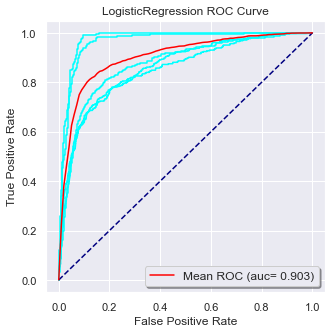


Train AUC: 0.904


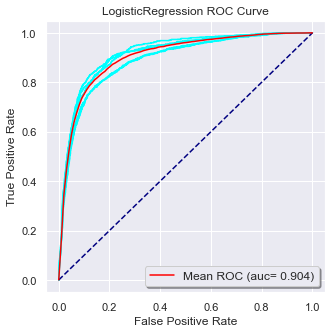

In [60]:
best_params_lr = {
    'penalty': 'l1', 
    'C': 10, 
    'tol': 0.01,
    'class_weight': 'balanced', 
    'solver': 'liblinear',
    'random_state': 0,
    'dual': False, # default param
    'fit_intercept': True, # default param
    'intercept_scaling': 1, # default param
    'max_iter': 100, # default param
    'multi_class': 'auto', # default param
    'verbose': 0, # default param 
    'warm_start': False, # default param
    'n_jobs': -1,
    'l1_ratio': None # default param
}


lr = LogisticRegression(**best_params_lr)
# Running the model on the validation data:

lr_val = Kfold_plot_auc(X[model_features], y, lr, 5, False)

# Running the model on the train data:
lr_train = Kfold_plot_auc(X[model_features], y, lr, 5, True)


## KNN
In order to find the best amount of neighbors to the K Nearest Neighbors model, we performed a grid search and found that 100 neighbors is the best amount for maximizing the validation score. We also set the weights on 'distance', meaning that closer neighbors to the sample will have a greater influence rather than far neighbors. The distance was calclated by manhattan distance.

In general we can see that this model gave a bit worse results than the Logisitic regression.
The train result of this model is very high, but it doesn't overfit as the validation and training score are quite close. In addition,the training score doesn't reduces even after increasing the neighbors number to 1000, so we don't suspect overfitting on this model.  


In [61]:
# #Grid search on KNN:

knn = KNeighborsClassifier()

params = {
    'n_neighbors' : [50, 100, 150],
    'p' : [1, 2],
    'weights' : ['uniform', 'distance'],
    'metric' : ['minkowski'],
    'n_jobs': [-1]
 }

grid = GridSearchCV(estimator= knn, param_grid=params, scoring='roc_auc', cv=5, n_jobs=-1)
grid.fit(X_train_raw[model_features] ,y_train)
best_params_knn = grid.best_params_
best_score_knn = (grid.best_score_)
print(f'Best Params: {best_params_knn} \n')


Best Params: {'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 100, 'p': 1, 'weights': 'distance'} 




Validation AUC: 0.899


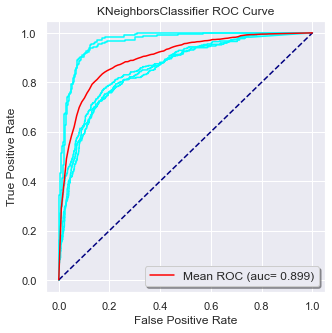


Train AUC: 0.995


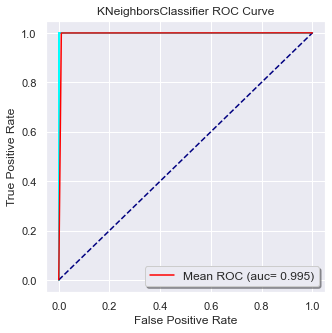

In [62]:
best_params_knn = {
                   'n_neighbors': 100,
                   'p': 1,
                   'weights': 'distance',
                   'algorithm': 'auto', # default param
                   'leaf_size': 30, # default param
                   'metric' : 'minkowski', # default param
                   'metric_params': None, # default param
                   'n_jobs': -1
                   }

knn_best = KNeighborsClassifier(**best_params_knn) # Running the model with the best parmas, based on gridsearch.
Kfold_plot_auc(X[model_features], y, knn_best, 5, False) # Running Kfold cross validation with 5 folds.

Kfold_plot_auc(X[model_features], y, knn_best, 5, True)

## Random Forest
The random forest model provided the best validation score so far, we set the trees number to 500, and limited the max depth of the trees to 8, and increased the minimum sample per split to 5 in order to reduce overfitting. 



In [63]:
# Grid search on Random Forest:

rnf =  RandomForestClassifier()
params = {
    'n_estimators':[500, 800, 1000],
    'max_depth':[8],
    'criterion':['gini', 'entropy'],
    'min_samples_leaf':[5],   
    'min_samples_split':[2],
    'random_state' : [0],
    'n_jobs': [-1]
 }

grid = GridSearchCV(estimator= rnf, param_grid = params, scoring='roc_auc', cv=5, n_jobs = -1)
grid.fit(X_train_raw[model_features] ,y_train)
best_params_rnf = grid.best_params_
best_score_rnf = grid.best_score_
print(f'Best Params: {best_params_rnf} \n')

rnf_best = RandomForestClassifier(**best_params_rnf)


Best Params: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 0} 




Validation AUC: 0.921


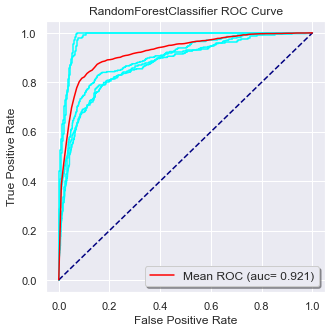


Train AUC: 0.959


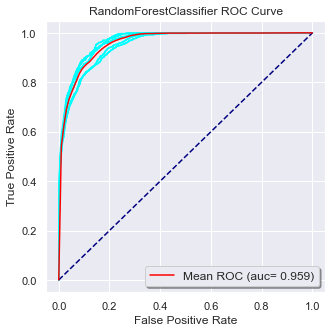

In [64]:
best_params_rnf = {
                   'n_estimators': 1000,
                   'criterion': 'entropy',
                   'max_depth': 8, 
                   'min_samples_split': 2, 
                   'min_samples_leaf': 5, 
                   'min_weight_fraction_leaf': 0, # default param
                   'max_features': 'sqrt', # default param
                   'max_leaf_nodes': None,  # default param
                   'min_impurity_decrease': 0.0,  # default param
                   'bootstrap': True, # default param
                   'oob_score': False, # default param
                   'n_jobs': -1,
                   'random_state': 0, 
                   'verbose': 0, # default param 
                   'warm_start': False, # default param
                   'class_weight': None, # default param
                   'ccp_alpha': 0.0, # default param
                   'max_samples': None # default param
}

# Let's plot to see the validation score after 5 folds
rnf_best = RandomForestClassifier(**best_params_rnf)
Kfold_plot_auc(X[model_features], y, rnf_best, 5, False)

# Plot of train AUC to check that we aren't overfitted
Kfold_plot_auc(X[model_features], y, rnf_best, 5, True)

## SVM
The last model we run is the Support vector machine.
We performed a random search on the data due to runtime limitations, and we chose C hyperparameter to be 100, so the penalization would be minimal, and chose a linear kernel as it gave us good performance, without complexing the model with non-linear kernels.
The model's score are decent, but the lowest we achieved so far.In addition it doesn't overfit.


In [65]:
#  Random search on SVM:

svmc = svm.SVC()
params = {'C': [1, 10],
           'kernel': ['linear','rbf'],
           'gamma' : ['auto'],
           'tol' : [0.001, 0.1],
           'random_state' : [0],
           'probability': [True]
           }

rand = RandomizedSearchCV(estimator= svmc, param_distributions = params, scoring='roc_auc', cv=5,n_jobs=-1)
rand.fit(X_train_raw[model_features] ,y_train)
best_params_svm = rand.best_params_
best_score_svm = (rand.best_score_)
print(f'Best Params: {best_params_svm} \n')


Best Params: {'tol': 0.1, 'random_state': 0, 'probability': True, 'kernel': 'linear', 'gamma': 'auto', 'C': 1} 




Validation AUC: 0.89


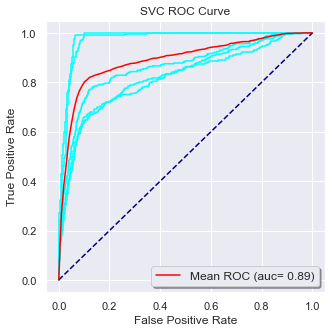


Train AUC: 0.894


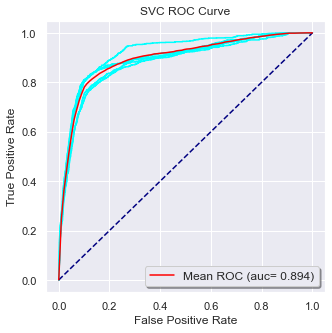

In [66]:
best_params_svm = {
                   'C': 1, # default param
                   'kernel': 'linear',
                   'degree': 3, # default param
                   'gamma': 'auto', 
                   'coef0': 0.0, # default param
                   'shrinking': True, # default param
                   'probability': True, 
                   'tol': 0.1, 
                   'cache_size': 200, # default param
                   'class_weight': None, # default param
                   'verbose': False, # default param
                   'max_iter': - 1, # default param
                   'decision_function_shape': 'ovr', # default param
                   'break_ties': False, # default param
                   'random_state': 0

}


svm_best = svm.SVC(**best_params_svm)
Kfold_plot_auc(X[model_features], y, svm_best, 5, False)

Kfold_plot_auc(X[model_features], y, svm_best, 5, True)


# Model Evaluation
Finally, we decided to choose the Random Forest model, this model has the best results for the validation sets, and we reduced the over fitting of this model by setting the max depth parameter to 8 so we are limiting the abillity of the alogorithm to overfit, thus we got not overfitted train auc results! 


## Confusion Matrix



Let's plot a confusion matrix and understand what it means:

**TP** (top left): users who we predicted they will make a purchase and they actually did.

**FP** (top right): users who we predicted they will make a purchase, but actually they haven't buy. (Type II error)

**FN** (bottom left): users who we predicted they won't make a purchase, but they actually did (Type I error)

**TN** (bottom right): users who we predicted they won't make a purchase, and they actually haven't.

Each cell represents the amount of users in the specific cell.

In our specific project, we will estimate 3 main metrics:

**Specificity**: The amount of users we caught that haven't made a purchase from the total amount of users that haven't bought. In our model we can see that the specificity is super high, meaning we have a tiny amount of "false alarms" (users who haven't made a purchase buy we predicted they will).
That means that we can enure to our executives that our model will catch almost every user who didn't buy, and to use this data for business purposes, such as understanding why the conversion rate is so low. 

**Recall**: The amount of users we caught which made a purchase, from the total amount of users that made a purchase.

We can see that the recall is about 60%, that means that our model doesn't perform well on distinguishing between the users who made a purachse.
We suggest that catching the users who bought is way harder then catching the ones how didn't, and that's because the decision to buy is not always rational. However, in bussines perspective, a user who made a purchase but we didn't catch it, isn't necessaraly a bad thing, it's a nice surprise for us anyhow, as we haven't invested resources on him and still he/she bought.
  
**Precision**: The amount of users we caught which made a purchase, from the total amount of users that we predicted they will.
We can see that this score is decent, where more than 77% of the users we predicted they will make a purchase, actually did. Comparing to the Recall and false negative, false alarms (false positive) is something we would like to avoid, as it probably will require investing resources such as targeting the user, and we are willing to invest on users who are really intending to buy, therfore this metric indicates decent results.   



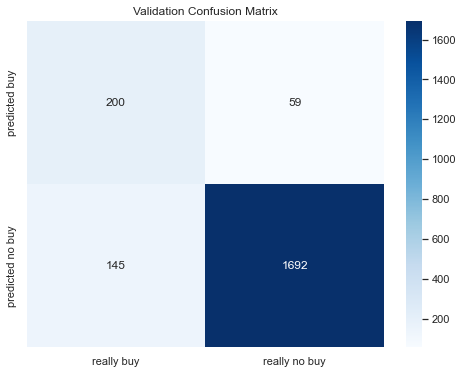

Validation AUC: 0.931
Recall/Sensitivity Score: 0.58
Specificity Score: 0.966
Precision Score: 0.772


In [67]:
best_params_rnf = {
                   'n_estimators': 1000,
                   'criterion': 'entropy',
                   'max_depth': 8, 
                   'min_samples_split': 2, 
                   'min_samples_leaf': 5, 
                   'min_weight_fraction_leaf': 0, # default param
                   'max_features': 'sqrt', # default param
                   'max_leaf_nodes': None,  # default param
                   'min_impurity_decrease': 0.0,  # default param
                   'bootstrap': True, # default param
                   'oob_score': False, # default param
                   'n_jobs': -1,
                   'random_state': 0, 
                   'verbose': 0, # default param 
                   'warm_start': False, # default param
                   'class_weight': None, # default param
                   'ccp_alpha': 0.0, # default param
                   'max_samples': None # default param
}


rnf_best = RandomForestClassifier(**best_params_rnf)
rnf_best.fit(X_train_raw[model_features], y_train)

preds_cm = rnf_best.predict(X_val_raw[model_features])
preds_prob_cm = rnf_best.predict_proba(X_val_raw[model_features])[:,1]
cm = confusion_matrix(y_val, preds_cm) # add predictions of the chosen model
tn, fp, fn, tp = cm.ravel()
cm = np.array([[tp,fp],
              [fn,tn]])
    
fpr, tpr, thresholds = roc_curve(y_val, preds_prob_cm)
valid_auc = auc(fpr,tpr)
# plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', yticklabels = ["predicted buy","predicted no buy"], xticklabels = ["really buy","really no buy"]).set_title('Validation Confusion Matrix')
plt.show()

print('Validation AUC:',round(valid_auc,3))

recall = tp / (tp+fn)
specificity = tn / (tn+fp)
precision = tp / (tp+fp)

print(f"Recall/Sensitivity Score: {recall.round(3)}")
print(f"Specificity Score: {specificity.round(3)}")
print(f"Precision Score: {precision.round(3)}")


## Feature importance
In order to understand which feature is influencing the model the most, we can check the feature importance of our chosen model, and to understand from it what is effecting stronger.

We can see from the plot that "Page Values" has the most important effect on our model, which makes sense, as this Google analytics metric is used by the biggest E-Commerce companies, and is helping to increase the revenue, and we saw it has positive correlation with the label durin the explorization step

We are happy to see that this feature was pre-proccessed correctly, as it helped us to get a very high auc.



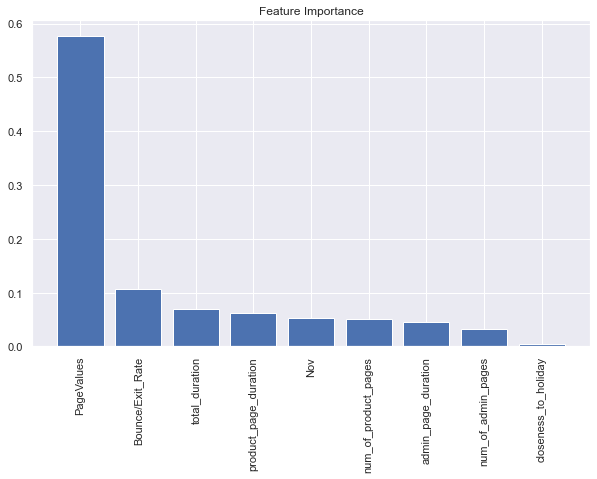

In [68]:

importances = rnf_best.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = X_train_raw[model_features].columns[indices]

# Create plot
plt.figure(figsize=(10,6))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_train_raw[model_features].shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train_raw[model_features].shape[1]), names, rotation=90)

# Show plot
plt.show()

In order to illustrate how much page values is important to our prediction, let's try to run the Random Forest model without it, and see if it effects the auc score. This model takes anyway only a square root of random features on each decision tree, so let's see how it handles without this important feature on each and every tree. 

We can see the huge degredation in the results: AUC score dropped below 0.76!


In [69]:
model_features_without_PV = [feat for feat in model_features if feat!= 'PageValues']
rnf_best.fit(X_train_raw[model_features_without_PV], y_train)
preds_cm = rnf_best.predict(X_val_raw[model_features_without_PV])
preds_prob_cm = rnf_best.predict_proba(X_val_raw[model_features_without_PV])[:,1]
fpr, tpr, thresholds = roc_curve(y_val, preds_prob_cm)
valid_auc = auc(fpr,tpr)
print('Validation AUC without PageValues:',round(valid_auc,3))


Validation AUC without PageValues: 0.755


# Submitting the results

In [70]:
# fitting the model for the last time, with all of the Train.csv data, so we will have maximum data for prediction
rnf_best = RandomForestClassifier(**best_params_rnf)
rnf_best.fit(X[model_features], y)

# Predicting the probabilities for the *real* test data
prob_test = rnf_best.predict_proba(data_for_submmission)[:,1]

#converting the variable to csv for submission
test_prob = pd.DataFrame(prob_test)
test_prob.to_csv('Submission_group_23.csv', header = ['predict_prob'])

# Pipeline to run test predictions



## Imports and installations

In [71]:

!pip install scipy
!pip install seaborn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import auc
from sklearn.decomposition import PCA
from sklearn.metrics import RocCurveDisplay, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, auc, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif
from sklearn.metrics import roc_curve
from scipy import stats
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from scipy import stats
from scipy.stats.mstats import winsorize
from numpy import interp
from sklearn import svm
from typing import Dict ,List


data = pd.read_csv("train.csv")
pd.set_option('display.max_columns', None)

# load test dataset
data_test = pd.read_csv("test.csv")
pd.set_option('display.max_columns', None)

## Preprocessing train data
We are preprocessing the train data becuase it stores values which we're intrestend in, so we can implement them on the test data.

In [72]:
# We want to change the durations features to float, so we can make calculations on this feature
data['product_page_duration'] = data['product_page_duration'].str.replace(' minutes', '').astype('float')
data['info_page_duration'] = data['info_page_duration'].str.replace(' minutes', '').astype('float')

data.drop('id',axis=1, inplace=True)

# as we can see, there are a lot of outliers in this features, in order to get a representative value, we will choose the median as the parameter to fill it.
Orig_Med_NOPP=data['num_of_product_pages'].median()
Orig_Med_NOAP=data['num_of_admin_pages'].median()
Orig_Med_NOIP=data['num_of_info_pages'].median()
Orig_Med_APD=data['admin_page_duration'].median()
Orig_Med_IPD=data['info_page_duration'].median()
Orig_Med_PPD=data['product_page_duration'].median()

data['num_of_product_pages']= data['num_of_product_pages'].fillna(Orig_Med_NOPP)
data['num_of_admin_pages']= data['num_of_admin_pages'].fillna(Orig_Med_NOAP)
data['num_of_info_pages']= data['num_of_info_pages'].fillna(Orig_Med_NOIP)

data['admin_page_duration'] = data['admin_page_duration'].fillna(Orig_Med_APD)
data['info_page_duration'] = data['info_page_duration'].fillna(Orig_Med_IPD)
data['product_page_duration'] = data['product_page_duration'].fillna(Orig_Med_PPD)


#fill the null's of total duration by summing info+product+admin
data['total_duration']= data['total_duration'].fillna(data['admin_page_duration'] + data['info_page_duration']+data['product_page_duration'])


# again we see that the google analytics features have a lot of outliers, we'll choose to fill the na values with the median.
Orig_Med_BR=data['BounceRates'].median()
Orig_Med_ExR=data['ExitRates'].median()
Orig_Med_PVs=data['PageValues'].median()

data['BounceRates']= data['BounceRates'].fillna(Orig_Med_BR)
data['ExitRates']= data['ExitRates'].fillna(Orig_Med_ExR)
data['PageValues']= data['PageValues'].fillna(Orig_Med_PVs)

# Weekend feature has tiny amount of na values. We saw that the weekend sessions are quite rare, we will fill the na with false
data['Weekend']=data['Weekend'].fillna(False)

# Merging simillar values in the internet browser feature:
data.loc[data['internet_browser'].str.contains('Chrome',case=False,na=False), 'internet_browser'] = 'Chrome' 
data.loc[data['internet_browser'].str.contains('safari',case=False,na=False), 'internet_browser'] = 'Safari' 
data.loc[data['internet_browser'].str.contains('edge',case=False,na=False), 'internet_browser'] = 'Edge' 
data.loc[data['internet_browser'].str.contains('browser',case=False,na=False), 'internet_browser'] = 'Other Browsers' 

# Fill region and month by the most common value of each feature.
Orig_Reg=data['Region'].value_counts().idxmax()
data['Region'] = data['Region'].fillna(Orig_Reg)
Orig_Month=data['Month'].value_counts().idxmax()
data['Month'] = data['Month'].fillna(Orig_Month)

# Fill the user type na by new users, we will assume that they are new as we don't know for sure that they are returning visitors.
data['user_type'] = data['user_type'].fillna('New_Visitor')

# fill closeness to holiday by the median , as most of the samples are around 0
Orig_Med_of_CTH=data['closeness_to_holiday'].median()
data['closeness_to_holiday'] = data['closeness_to_holiday'].fillna(Orig_Med_of_CTH)

Orig_Device_nulls=data['device'].isnull()
Orig_Device_valcount=data['device'].value_counts()
# We saw that the devices are distributes in the following way: 2.0 is the most common with half of the samples, the 1.0 and 3.0 is 25% let's fill the na's corespondelly:
print("Device na values before change:",Orig_Device_nulls.sum())
data['device'] = data['device'].fillna(Orig_Device_valcount.idxmax(),limit=int(round(Orig_Device_nulls.sum()*0.5)))
data['device'] = data['device'].fillna(Orig_Device_valcount[1:].idxmax(),limit=int(round(Orig_Device_nulls.sum()*0.5))) #half of nulls is left, we want to fill another 25%
data['device'] = data['device'].fillna(Orig_Device_valcount[2:].idxmax()) # 25% of nulls is left, we want to fill the rest 25%
print("Device na values after change:",data['device'].isnull().sum())

Orig_brows_nulls=data['internet_browser'].isnull()
Orig_brows_valcount=data['internet_browser'].value_counts()
# After ploting the internet browser feature, it distributes in the following way: chrome is the largest with 0.6 of the data, then Safari with 0.2 and Browser and Edge with 0.1
print("\nBrowser na values Before change:",data['internet_browser'].isnull().sum())

data['internet_browser'] = data['internet_browser'].fillna(Orig_brows_valcount.idxmax(),limit=int(round(Orig_brows_nulls.sum()*0.6)))
data['internet_browser'] = data['internet_browser'].fillna(Orig_brows_valcount[1:].idxmax(),limit=int(round(Orig_brows_nulls.sum()*0.5))) #40% of nulls is left, we want to fill another 20% 
data['internet_browser'] = data['internet_browser'].fillna(Orig_brows_valcount[2:].idxmax(),limit=int(round(Orig_brows_nulls.sum()*0.5))) # 20% of nulls is left, we want to fill another 10%
data['internet_browser'] = data['internet_browser'].fillna(Orig_brows_valcount[3:].idxmax()) # 10% of nulls is left, we want to fill the rest 10%
print("Browser na values After change:",data['internet_browser'].isnull().sum())


# 'B' feature is a normal distributed feature, therefore we will fill it with it's mean value
Orig_mean_B=data['B'].mean()
data['B'] = data['B'].fillna(Orig_mean_B)

data.loc[data['C'].str.contains('40',case=False,na=False), 'C'] = 1
data.loc[data['C'].str.contains('20|10|8080',case=False,na=False), 'C'] = 0

# now let's fill na's with success values, becuase we can assume that most of the http requests will return a non error.
data['C'] = data['C'].fillna(0)

A_unique = data['A'].unique()

data.drop(['A', 'D'], axis=1, inplace=True)

# first we would change the bool features we have to be numeric, 0 for no and 1 for yes, we will start with purchase:
data['purchase'] = data['purchase'].astype(int)

# Replace boolean to binaryת 
data['Weekend'] = data['Weekend'].map({True: 1, False: 0})   

# sainity check
print("Weekend feature unique values:",data['Weekend'].unique())


# We see that Bounce & Exit rates are behaving the same way, and they also have extremely high correlation (0.91), We suggest to unite them and to reduce features by that.
data['Bounce/Exit_Rate'] = (data['BounceRates']+data['ExitRates'])/2
data.drop('BounceRates' ,axis=1, inplace=True)
data.drop('ExitRates',axis=1, inplace=True)

# from this plotting, we decided that the features that distributes normally are:
Norm_feat= ['product_page_duration','total_duration','B']

# saving normal features mean and std for test pre proccess step.
Norm_feat_mean = [data[feat].mean() for feat in Norm_feat]
Norm_feat_std = [data[feat].std() for feat in Norm_feat]

# The other features will be marked as minmax, that's for the normalization part
MinMax_feat=['PageValues', 'Bounce/Exit_Rate','closeness_to_holiday', 'admin_page_duration',
             'num_of_product_pages','num_of_info_pages', 'num_of_admin_pages', 'info_page_duration'] 

# saving the original columns of minmax list for the test data preproccesing, so we won't make the same action on a feature twice
minmax_features_copy= data[MinMax_feat].copy(deep=True)

# As we can see those features have skewed samples, therefore, but we want to handle the outliers carefully, as we don't want to lose samples.
# Winsorization is the process of replacing the extreme values of statistical data in order to limit the effect of the outliers on the calculations or the results obtained by using that data.
# We would use the winsorize function to normilze the outliers to the 95% percentage upper limit. The lower limit will remain 0 and we don't want to cut from it, as most of the data in these features placed there!

tmp_list = ['product', 'admin', 'info']
outliers_dic = {}
for i in tmp_list:
  outliers_dic['transformed_{}_data'.format(i)] = pd.Series(winsorize(data['num_of_{}_pages'.format(i)], limits=[0.0, 0.05]))   
  data['num_of_{}_pages'.format(i)] = outliers_dic['transformed_{}_data'.format(i)]
  
data['info_page_duration']= winsorize(data['info_page_duration'], limits=[0, 0.05])

data['admin_page_duration']= winsorize(data['admin_page_duration'], limits=[0, 0.05])

data['PageValues']= winsorize(data['PageValues'], limits=[0, 0.05])

data['closeness_to_holiday']= winsorize(data['closeness_to_holiday'], limits=[0, 0.05])


# handling outliers of normal distributed features
threshold = 3

for feat in [feat for feat in Norm_feat if feat is not 'B']:
  mean = data[feat].mean()
  std = data[feat].std()
  bnd = std * threshold
  l_bnd = mean- bnd
  u_bnd = mean + bnd
  data.loc[data[feat] < l_bnd, feat] = l_bnd
  data.loc[data[feat] > u_bnd, feat] = u_bnd

# splitting the 5 categorial features into dummies
Set1= pd.get_dummies(data['Month'])
Set2=pd.get_dummies(data['internet_browser'])
Set3=pd.get_dummies(data['user_type'])

# merge them to our data
frames=[data,Set1,Set2,Set3]
merged=pd.concat(frames,axis='columns')

# dropping the old columns before encoding, and also the region and device columns we decided to disclude from our models. 
FixedData=merged.drop(['internet_browser','Month', 'user_type','Region','device'],axis='columns')
print("New Shape of our data after adding Categorials: " , FixedData.shape)

# data normalization
standard = StandardScaler()
minmax = MinMaxScaler()
FixedData[Norm_feat] = standard.fit_transform(FixedData[Norm_feat])
FixedData[MinMax_feat] = minmax.fit_transform(FixedData[MinMax_feat])

y=FixedData['purchase']
X= FixedData.drop('purchase',axis='columns')


Device na values before change: 323
Device na values after change: 0

Browser na values Before change: 563
Browser na values After change: 0
Weekend feature unique values: [0 1]
New Shape of our data after adding Categorials:  (10479, 31)


## Preproccessing test data

In [73]:

##### Preproccesing #####


data_test['product_page_duration'] = data_test['product_page_duration'].str.replace(' minutes', '').astype('float')
data_test['info_page_duration'] = data_test['info_page_duration'].str.replace(' minutes', '').astype('float')

## filling null values

# fill nulls of the  features with their train parameter that we saved previously.
data_test['num_of_admin_pages']= data_test['num_of_admin_pages'].fillna(Orig_Med_NOAP)
data_test['admin_page_duration'] = data_test['admin_page_duration'].fillna(Orig_Med_APD)
data_test['info_page_duration'] = data_test['info_page_duration'].fillna(Orig_Med_IPD)
data_test['num_of_product_pages']= data_test['num_of_product_pages'].fillna(Orig_Med_NOPP)
data_test['product_page_duration'] = data_test['product_page_duration'].fillna(Orig_Med_PPD)
data_test['num_of_info_pages']= data_test['num_of_info_pages'].fillna(Orig_Med_NOIP)

data_test['BounceRates']= data_test['BounceRates'].fillna(Orig_Med_BR)
data_test['ExitRates']= data_test['ExitRates'].fillna(Orig_Med_ExR)
data_test['PageValues']= data_test['PageValues'].fillna(Orig_Med_PVs)

data_test['closeness_to_holiday'] = data_test['closeness_to_holiday'].fillna(Orig_Med_of_CTH)
data_test['Month'] = data_test['Month'].fillna(Orig_Month)
data_test['B'] = data_test['B'].fillna(Orig_mean_B)

# fill the null's of total duration by summing info + product + admin
data_test['total_duration']= data_test['total_duration'].fillna(data_test['admin_page_duration'] + data_test['info_page_duration']
                                                                +data_test['product_page_duration'])

# fill the weekend nulls with false, as based on the train data, it's likely that the session occured on a regular day
data_test['Weekend']=data_test['Weekend'].fillna(False)

# fill the user type na by new users, we will assume that they are new as we don't know for sure that they are returning
data_test['user_type'] = data_test['user_type'].fillna('New_Visitor')

## Handling categorial features

# Merging simillar values in the internet browser feature:
data_test.loc[data_test['internet_browser'].str.contains('Chrome',case=False,na=False), 'internet_browser'] = 'Chrome' 
data_test.loc[data_test['internet_browser'].str.contains('safari',case=False,na=False), 'internet_browser'] = 'Safari' 
data_test.loc[data_test['internet_browser'].str.contains('edge',case=False,na=False), 'internet_browser'] = 'Edge' 
data_test.loc[data_test['internet_browser'].str.contains('browser',case=False,na=False), 'internet_browser'] = 'Other Browsers' 

# fill the browser nulls with the distribution of the train data: chrome is the largest with 0.6 of the data, then Safari with 0.2 and Browser and Edge with 0.1
print("\nBrowser na values Before change (in data test):",data_test['internet_browser'].isnull().sum())
data_test['internet_browser'] = data_test['internet_browser'].fillna(Orig_brows_valcount.idxmax(),limit=int(round(Orig_brows_nulls.sum()*0.6)))
data_test['internet_browser'] = data_test['internet_browser'].fillna(Orig_brows_valcount[1:].idxmax(),limit=int(round(Orig_brows_nulls.sum()*0.5))) #40% of nulls is left, we want to fill another 20% 
data_test['internet_browser'] = data_test['internet_browser'].fillna(Orig_brows_valcount[2:].idxmax(),limit=int(round(Orig_brows_nulls.sum()*0.5))) # 20% of nulls is left, we want to fill another 10%
data_test['internet_browser'] = data_test['internet_browser'].fillna(Orig_brows_valcount[3:].idxmax()) # 10% of nulls is left, we want to fill the rest 10%
print("Browser na values After change (in data test):",data_test['internet_browser'].isnull().sum())

# Replace boolean to binary
data_test['Weekend'] = data_test['Weekend'].map({True: 1, False: 0})      

# handling the 'C' feature: We would like to set binary representation, of 1 as an error, and 0 as no error
data_test.loc[data_test['C'].str.contains('40',case=False,na=False), 'C'] = 1
data_test.loc[data_test['C'].str.contains('20|10|8080',case=False,na=False), 'C'] = 0

# fill 'C' nulls with success values, becuase we can assume that most of the http requests will return a non error.
data_test['C'] = data_test['C'].fillna(0)
data_test['C'].unique()

## New Features to the test set
data_test['Bounce/Exit_Rate'] = (data_test['BounceRates']+data_test['ExitRates'])/2

## drop unnecessary columns
data_test.drop('BounceRates' ,axis=1, inplace=True)
data_test.drop('ExitRates',axis=1, inplace=True)
data_test.drop(['A', 'D'], axis=1, inplace=True)

## outliers
# features divison by normal distributed and non normal
Norm_feat= ['product_page_duration','total_duration','B']
MinMax_feat=['PageValues', 'Bounce/Exit_Rate','closeness_to_holiday', 'admin_page_duration', 'num_of_product_pages','num_of_info_pages', 'num_of_admin_pages', 'info_page_duration'] 


# handling outliers in normal distributed features (except 'B' that we is perfect noramlized so no outliers removal is required)
# we would like to use the mean and std of the train data, that we saved earlier 
threshold = 3
i = 0
for feat in [feat for feat in Norm_feat if feat is not 'B']:
  mean = Norm_feat_mean[i]
  std = Norm_feat_std[i]
  bnd = std * threshold
  l_bnd = mean- bnd
  u_bnd = mean + bnd
  data_test.loc[data_test[feat] < l_bnd, feat] = l_bnd
  data_test.loc[data_test[feat] > u_bnd, feat] = u_bnd
  i += 1



# handling outliers of non normal distributed features: by winsorizing. Bounce/Exit Rates feature is skipped becuase of his unique distribution and in order not to corrupt it. 
tmp_list = ['product', 'admin', 'info']
outliers_dic = {}
for i in tmp_list:
  outliers_dic['transformed_{}_data'.format(i)] = pd.Series(winsorize(minmax_features_copy['num_of_{}_pages'.format(i)], limits=[0.0, 0.05]))   
  data_test['num_of_{}_pages'.format(i)] = outliers_dic['transformed_{}_data'.format(i)]

data_test['info_page_duration']= pd.Series(winsorize(minmax_features_copy['info_page_duration'], limits=[0, 0.05]))

data_test['admin_page_duration']= pd.Series(winsorize(minmax_features_copy['admin_page_duration'], limits=[0, 0.05]))

data_test['PageValues']= pd.Series(winsorize(minmax_features_copy['PageValues'], limits=[0, 0.05]))

data_test['closeness_to_holiday']= pd.Series(winsorize(minmax_features_copy['closeness_to_holiday'], limits=[0, 0.05]))

# adding dummies
print("Shape of our data Before adding Categorials: " , data_test.shape)  
Set_of_Month_TEST= pd.get_dummies(data_test['Month'])
Set_of_User_Type_TEST=pd.get_dummies(data_test['user_type'])
Set_of_Brows_TEST=pd.get_dummies(data_test['internet_browser'])

Curr_frames=[data_test,Set_of_Month_TEST,Set_of_User_Type_TEST,Set_of_Brows_TEST]
Curr_merged=pd.concat(Curr_frames,axis='columns')

Fixed_Test_Data=Curr_merged.drop(['id','internet_browser','Month', 'user_type','Region','device'],axis='columns')
               
print("New Shape after adding Categorials to test data: " , Fixed_Test_Data.shape)

# data normalization
standard = StandardScaler()
minmax = MinMaxScaler()

Fixed_Test_Data[Norm_feat] = standard.fit_transform(Fixed_Test_Data[Norm_feat])
Fixed_Test_Data[MinMax_feat] = minmax.fit_transform(Fixed_Test_Data[MinMax_feat])




Browser na values Before change (in data test): 107
Browser na values After change (in data test): 0
Shape of our data Before adding Categorials:  (1851, 19)
New Shape after adding Categorials to test data:  (1851, 30)


## Results Submission

In [74]:
# Picking the 9 final features our SelectKbest algorithm picked for us previously
model_features =  ['num_of_admin_pages', 'admin_page_duration', 'num_of_product_pages', 'product_page_duration',
  'total_duration', 'PageValues', 'closeness_to_holiday', 'Bounce/Exit_Rate', 'Nov']

data_for_submmission = Fixed_Test_Data[model_features]

## fitting the chosen model and submmiting the results:
best_params_rnf = {
                   'n_estimators': 1000,
                   'criterion': 'entropy',
                   'max_depth': 8, 
                   'min_samples_split': 2, 
                   'min_samples_leaf': 5, 
                   'min_weight_fraction_leaf': 0, # default param
                   'max_features': 'sqrt', # default param
                   'max_leaf_nodes': None,  # default param
                   'min_impurity_decrease': 0.0,  # default param
                   'bootstrap': True, # default param
                   'oob_score': False, # default param
                   'n_jobs': -1,
                   'random_state': 0, 
                   'verbose': 0, # default param 
                   'warm_start': False, # default param
                   'class_weight': None, # default param
                   'ccp_alpha': 0.0, # default param
                   'max_samples': None # default param
}

rnf_best = RandomForestClassifier(**best_params_rnf)
rnf_best.fit(X[model_features], y)

# Predicting the probabilities for the *real* test data
prob_test = rnf_best.predict_proba(data_for_submmission)[:,1]

#converting the variable to csv for submission
test_prob = pd.DataFrame(prob_test)
test_prob.to_csv('Submission_group_23.csv', header = ['predict_prob'])